# Alt Architecture

Inputs branch into two separate layers (one for vertical, one for horizontal) and get recombined by our final classification layer.

## Imports

In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from helpers import load_images, load_labels, visualize_image, get_edges, generate_intermediate_edge_labels

## Set Device to GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [3]:
# train data
train_images = load_images("./data/train-images-idx3-ubyte/train-images-idx3-ubyte")
train_labels = load_labels("./data/train-labels-idx1-ubyte/train-labels-idx1-ubyte")

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=1/6,  # 10k validation
    stratify=train_labels,
    random_state=42  # for reproducibility
)

# test data
test_images = load_images("./data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_labels("./data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

In [4]:
print("Train images shape:", train_images.shape)
print("Val images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (50000, 28, 28)
Val images shape: (10000, 28, 28)
Test images shape: (10000, 28, 28)


## Visualize an image

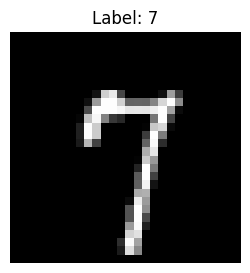

In [5]:
sample_image = train_images[0]
sample_label = train_labels[0]
visualize_image(sample_image, sample_label)

## Convolutions to get Horizontal Edges

### Example Image

In [6]:
horizontal_kernel = np.array([
    [-1, -1, -1],
    [ 0,  0 , 0],
    [ 1,  1,  1],
])

In [7]:
horizontal_edges = get_edges(horizontal_kernel, sample_image)

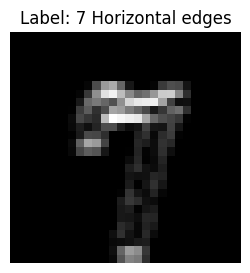

In [8]:
visualize_image(horizontal_edges, f"{sample_label} Horizontal edges")

### Extending the Dataset

In [9]:
train_horizontal_image_labels = generate_intermediate_edge_labels(train_images, horizontal_kernel)

In [10]:
val_horizontal_image_labels = generate_intermediate_edge_labels(val_images, horizontal_kernel)

In [11]:
test_horizontal_image_labels = generate_intermediate_edge_labels(test_images, horizontal_kernel)

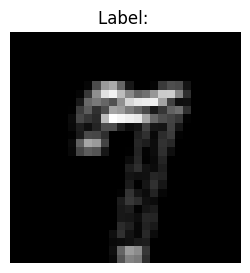

In [12]:
visualize_image(train_horizontal_image_labels[0].reshape(28, 28), "")

## Convolutions to get Vertical Edges

### Example Image

In [13]:
vertical_kernel = np.array([
    [-1,  0,  1],
    [-1,  0,  1],
    [-1,  0,  1],
])

In [14]:
vertical_edges = get_edges(vertical_kernel, sample_image)

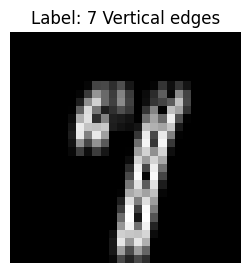

In [15]:
visualize_image(vertical_edges, f"{sample_label} Vertical edges")

### Extending the Dataset

In [16]:
train_vertical_image_labels = generate_intermediate_edge_labels(train_images, vertical_kernel)

In [17]:
val_vertical_image_labels = generate_intermediate_edge_labels(val_images, vertical_kernel)

In [18]:
test_vertical_image_labels = generate_intermediate_edge_labels(test_images, vertical_kernel)

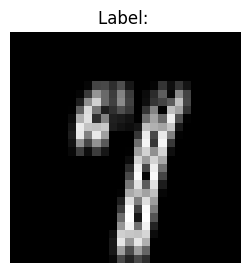

In [19]:
visualize_image(train_vertical_image_labels[0].reshape(28, 28), "")

# Our Test

## Architecture

We keep our two hidden layers at image size to be able to calculate a local loss to push those layers to learn human recognizable structures. However, for the example below, we don't calculate intermediate loss, as we need a basis.

In [20]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.horizontal_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.vertical_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.classification_layer = nn.Linear(layer_size_by_pixels, 10)
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # horizontal layer
        horizontal_out = self.horizontal_layer(x)
        horizontal_act = self.activation_function(horizontal_out)

        # vertical layer connected to horizontal layer
        vertical_out = self.vertical_layer(x)
        vertical_act = self.activation_function(vertical_out)

        combined_act = (vertical_act + horizontal_act) / 2

        # coupling layer
        classification_out = self.classification_layer(combined_act)
        
        return classification_out, vertical_act, horizontal_act

In [21]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [22]:
model = NeuralNetwork().to(device)

# loss functions
classification_loss_fn = nn.CrossEntropyLoss()
horizontal_loss_fn = nn.MSELoss()
vertical_loss_fn = nn.MSELoss()

# optimizers
optimizer = torch.optim.Adam(model.parameters())

In [23]:
print(f"Model weights (to compare below): {model.horizontal_layer.weight[0][:5].detach().cpu().numpy()}")

Model weights (to compare below): [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]


### Verify Reproducibility

In [24]:
# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
model_compare_one = NeuralNetwork().to(device)
first_set_of_weights = model_compare_one.horizontal_layer.weight[0][:5].detach().cpu().numpy()
print("First set of weights:", first_set_of_weights)

# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

model_compare_two = NeuralNetwork().to(device)
second_set_of_weights = model_compare_two.horizontal_layer.weight[0][:5].detach().cpu().numpy()
print("Second set of weights:", second_set_of_weights)

print(f"Are the two sets equal: {first_set_of_weights == second_set_of_weights}")

First set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Second set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Are the two sets equal: [ True  True  True  True  True]


## Dataloader

In [25]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels, horizontal_edges, vertical_edges):
        self.images = images
        self.labels = labels
        self.horizontal_edges = horizontal_edges
        self.vertical_edges = vertical_edges

    def __len__(self):
        assert len(self.images) == len(self.labels)
        return len(self.images)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.images[idx].copy()).float(),
            torch.tensor(self.labels[idx].copy(), dtype=torch.long),
            torch.from_numpy(self.horizontal_edges[idx].copy()).float(),
            torch.from_numpy(self.vertical_edges[idx].copy()).float(),
        )

In [26]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator().manual_seed(seed)

In [27]:
# training data
train_dataset = EdgeDataset(train_images, train_labels, train_horizontal_image_labels, train_vertical_image_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=generator)

# validation data
val_dataset = EdgeDataset(val_images, val_labels, val_horizontal_image_labels, val_vertical_image_labels)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)  # larger batch size for faster validation

# test data
test_dataset = EdgeDataset(test_images, test_labels, test_horizontal_image_labels, test_vertical_image_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

## Training Loop

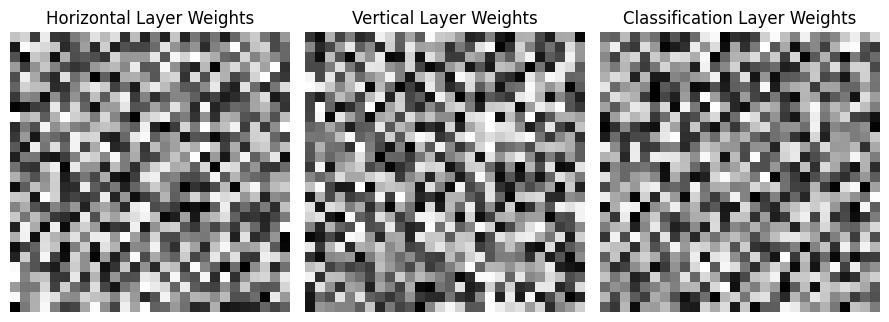

Epoch 1/20
  Train Loss: 0.8206
  Val Loss: 0.1648 | Val Acc: 95.42%


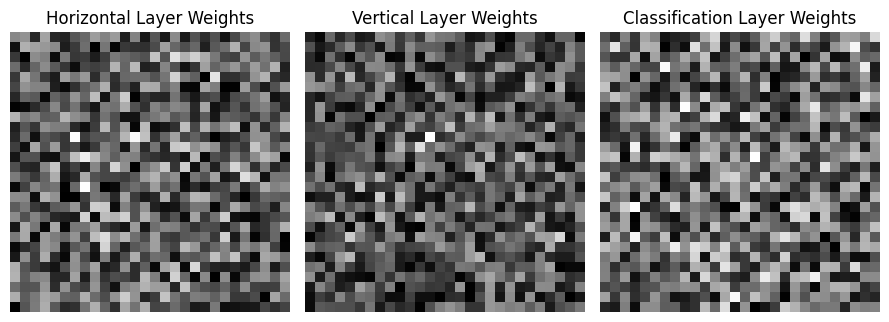

Epoch 2/20
  Train Loss: 0.1596
  Val Loss: 0.2068 | Val Acc: 95.66%


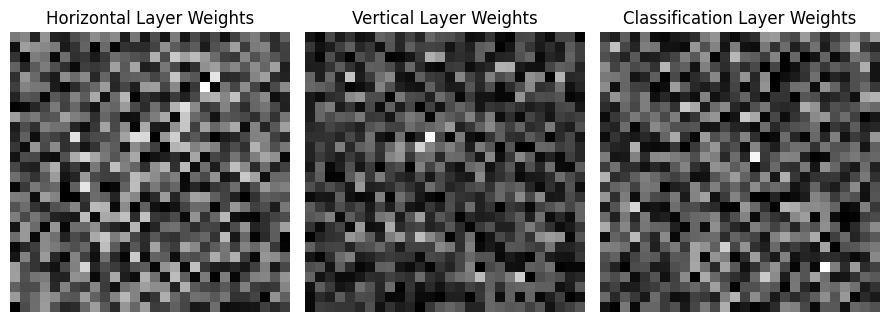

Epoch 3/20
  Train Loss: 0.1522
  Val Loss: 0.2054 | Val Acc: 95.86%


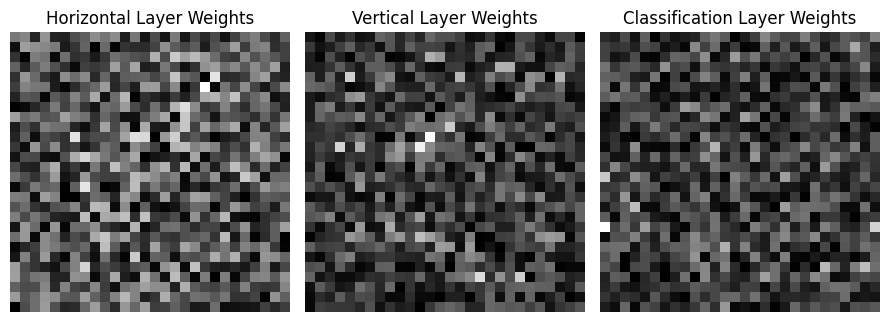

Epoch 4/20
  Train Loss: 0.1641
  Val Loss: 0.2527 | Val Acc: 94.94%


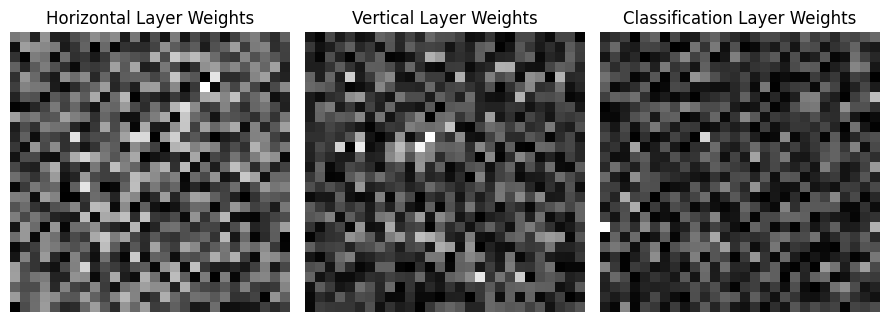

Epoch 5/20
  Train Loss: 0.1479
  Val Loss: 0.2560 | Val Acc: 95.27%


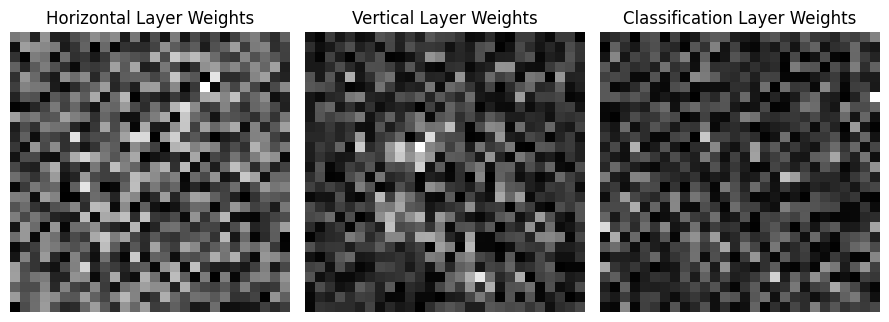

Epoch 6/20
  Train Loss: 0.1474
  Val Loss: 0.2112 | Val Acc: 96.12%


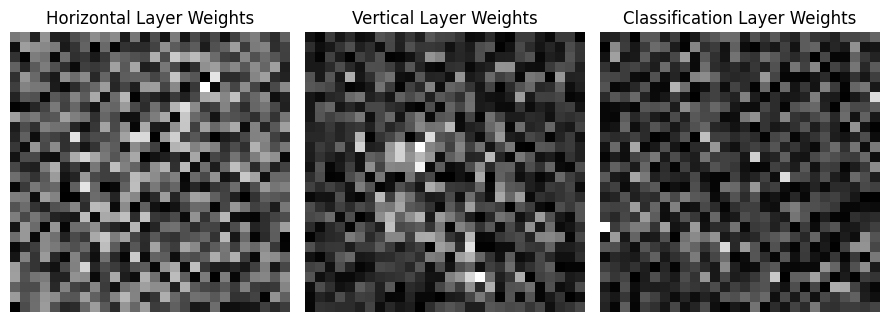

Epoch 7/20
  Train Loss: 0.1358
  Val Loss: 0.2197 | Val Acc: 96.42%


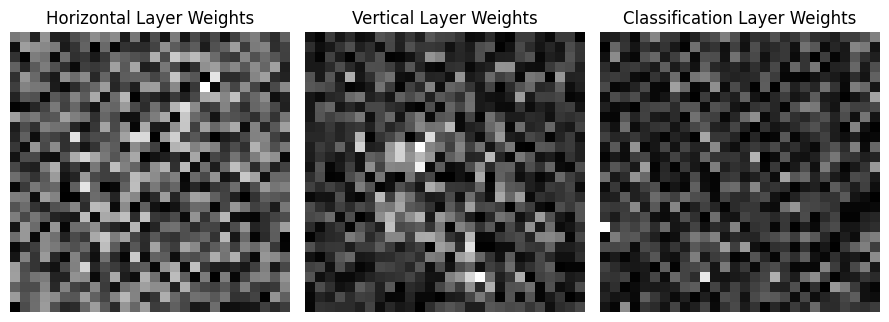

Epoch 8/20
  Train Loss: 0.1337
  Val Loss: 0.3387 | Val Acc: 96.10%


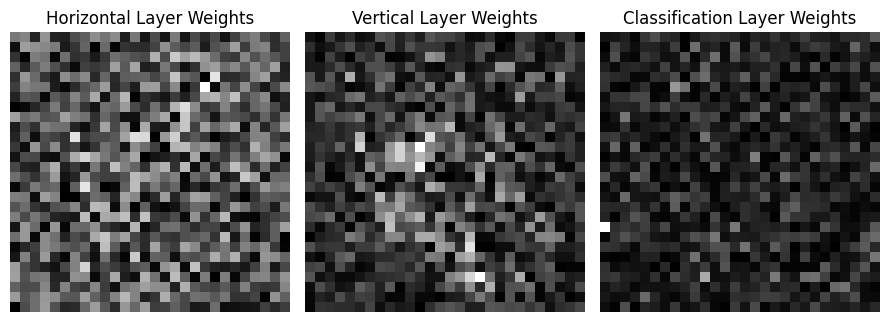

Epoch 9/20
  Train Loss: 0.1186
  Val Loss: 0.3059 | Val Acc: 96.64%


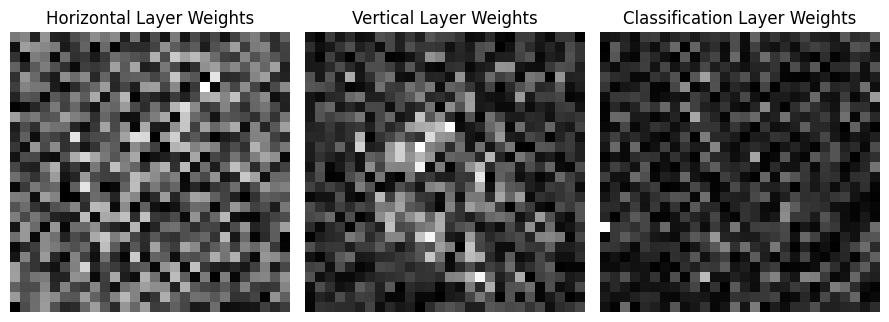

Epoch 10/20
  Train Loss: 0.1142
  Val Loss: 0.4051 | Val Acc: 96.25%


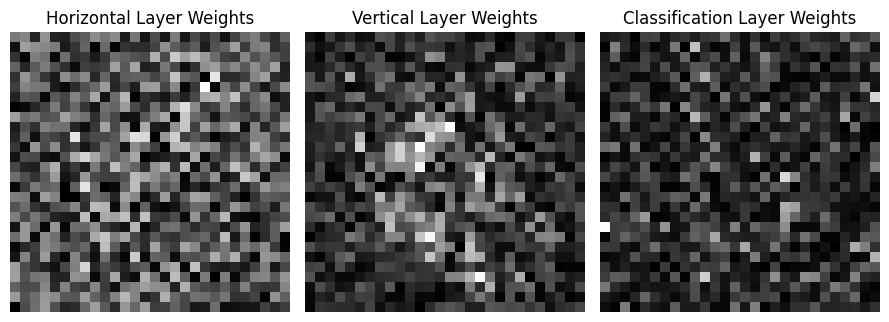

Epoch 11/20
  Train Loss: 0.1027
  Val Loss: 0.3719 | Val Acc: 96.12%


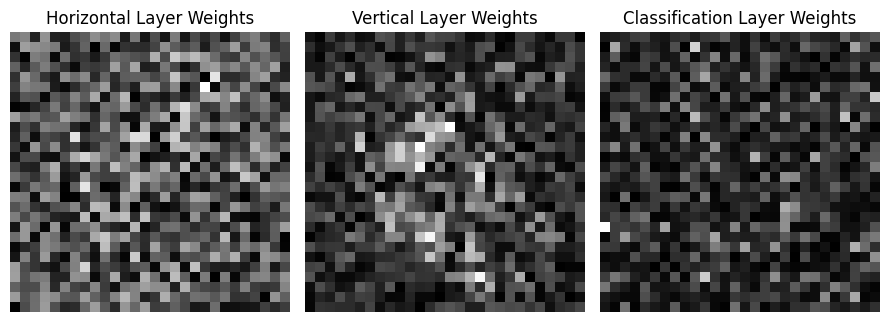

Epoch 12/20
  Train Loss: 0.1109
  Val Loss: 0.3370 | Val Acc: 96.70%


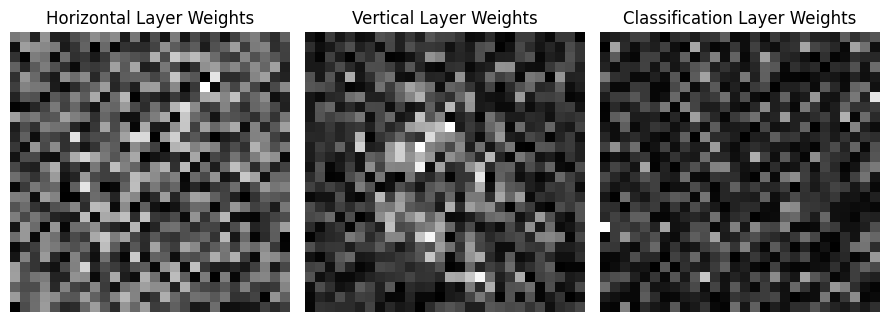

Epoch 13/20
  Train Loss: 0.0914
  Val Loss: 0.3286 | Val Acc: 96.90%


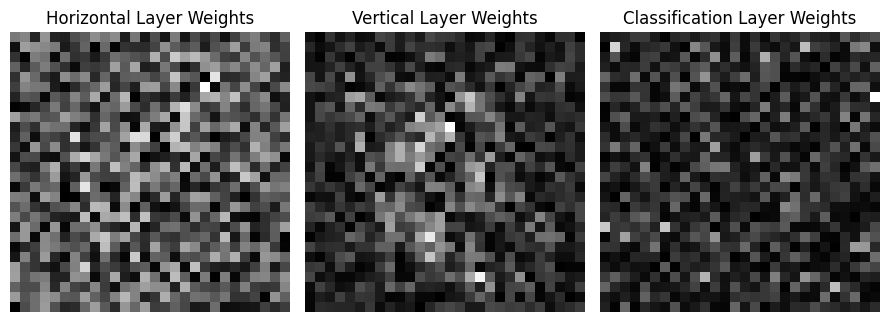

Epoch 14/20
  Train Loss: 0.1034
  Val Loss: 0.4019 | Val Acc: 96.90%


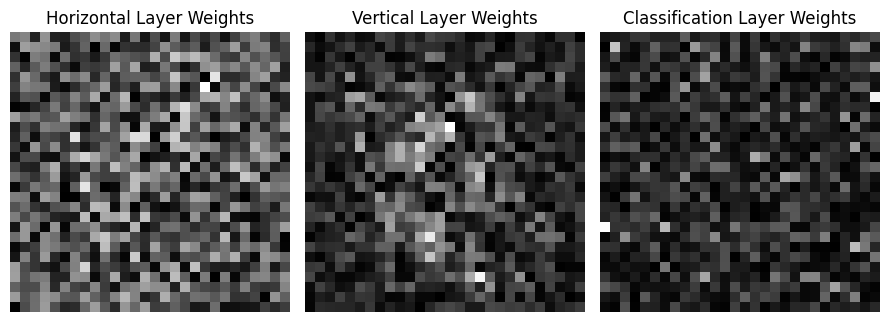

Epoch 15/20
  Train Loss: 0.0946
  Val Loss: 0.4421 | Val Acc: 96.80%


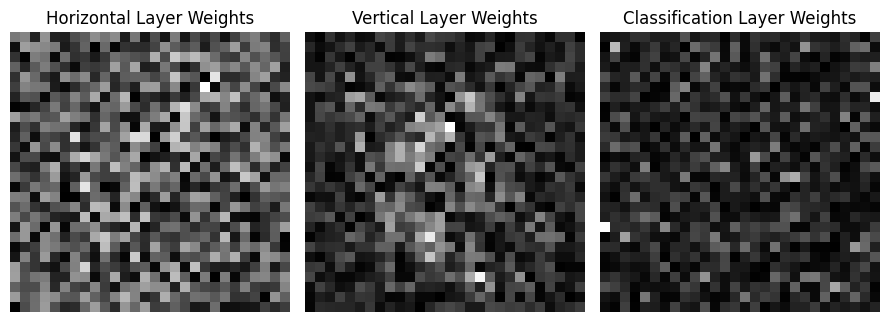

Epoch 16/20
  Train Loss: 0.0946
  Val Loss: 0.4792 | Val Acc: 96.90%


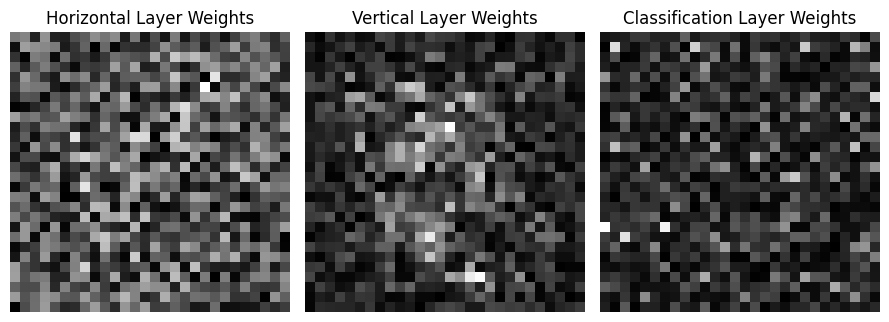

Epoch 17/20
  Train Loss: 0.0923
  Val Loss: 0.4479 | Val Acc: 96.97%


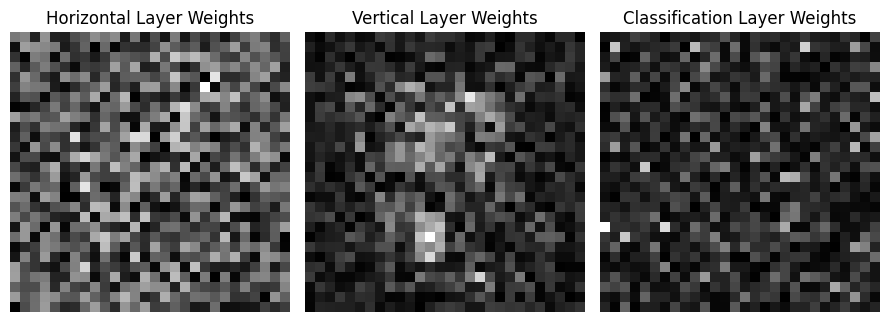

Epoch 18/20
  Train Loss: 0.1073
  Val Loss: 0.5257 | Val Acc: 96.88%


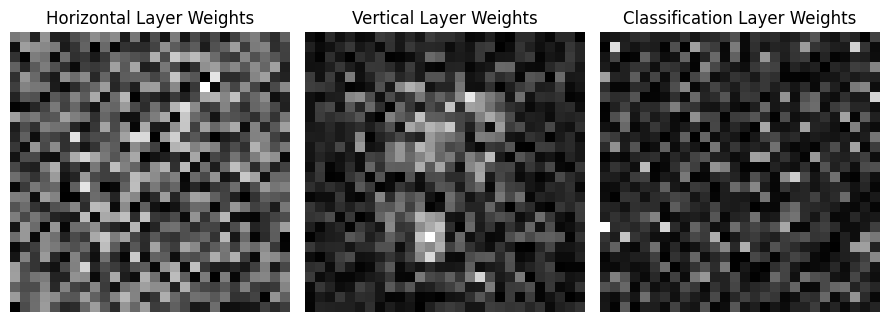

Epoch 19/20
  Train Loss: 0.0784
  Val Loss: 0.5927 | Val Acc: 96.35%


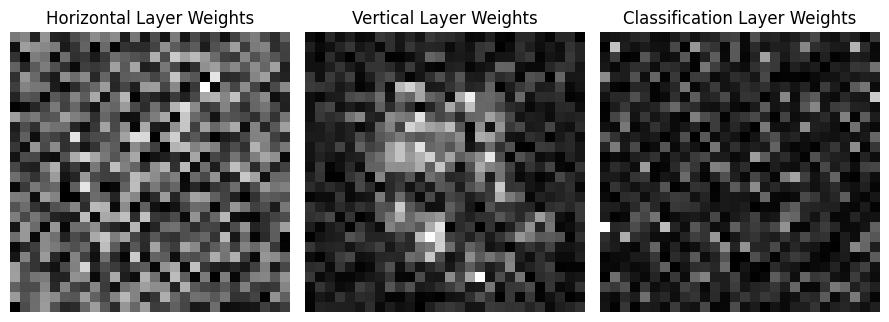

Epoch 20/20
  Train Loss: 0.0732
  Val Loss: 0.6337 | Val Acc: 96.69%


In [28]:
num_epochs = 20
best_val_loss = float('inf')
loss_factor = 0
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()  # set the model to training mode - this is currently a no-op
    train_loss = 0.0

    # visualize weights at each layer during training
    classification_w = np.abs(model.classification_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
    vertical_w = np.abs(model.vertical_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
    horizontal_w = np.abs(model.horizontal_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
    
    fig, axes = plt.subplots(1, 3, figsize=(9, 5))
    
    visualize_image(horizontal_w, "Horizontal Layer Weights", ax=axes[0])
    visualize_image(vertical_w, "Vertical Layer Weights", ax=axes[1])
    visualize_image(classification_w, "Classification Layer Weights", ax=axes[2])
    
    plt.tight_layout()
    plt.show()

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
    for batch in train_bar:
        # deconstruct batch items
        images, labels, horizontal_labels, vertical_labels = batch
        images, labels, horizontal_labels, vertical_labels = images.to(device), labels.to(device), horizontal_labels.to(device), vertical_labels.to(device)
        
        # forward pass
        classification_out, vertical_act, horizontal_act = model(images)
        
        # --- Loss and Backprop ---

        # clear gradients
        optimizer.zero_grad()

        # vertical loss
        vertical_loss = vertical_loss_fn(vertical_act, vertical_labels)

        # horizontal loss
        horizontal_loss = horizontal_loss_fn(horizontal_act, horizontal_labels)

        # classification loss
        classification_loss = classification_loss_fn(classification_out, labels)

        # total loss
        total_loss = loss_factor * (vertical_loss + horizontal_loss) + classification_loss
        total_loss.backward()
        
        optimizer.step()

        # update progress
        train_loss += total_loss.item()
        train_bar.set_postfix(loss=classification_loss.item())

    
    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for batch in val_bar:
            # deconstruct
            images, labels, _, _ = batch
            images, labels = images.to(device), labels.to(device)

            # forward pass
            classification_out, _, _ = model(images)

            # compute loss
            loss = classification_loss_fn(classification_out, labels)

            # calculate metrics
            val_loss += loss.item()
            _, predicted = torch.max(classification_out, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # epoch stats
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

## Eval

In [29]:
model.eval()  # again currently a no-op

test_correct = 0
test_total = 0

with torch.no_grad():
    test_bar = tqdm(test_loader, desc=f"Evaluation")
    for batch in test_bar:
        images, labels, _, _ = batch
        images, labels = images.to(device), labels.to(device)

        # forward pass
        classification_out, _, _ = model(images)

        # stats
        _, predicted = torch.max(classification_out, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

Evaluation: 100%|█████████████████████████████████| 79/79 [00:00<00:00, 411.87it/s]

Final Test Accuracy: 96.59%


# Exploring the Resulting Model

## Visualizing Weights

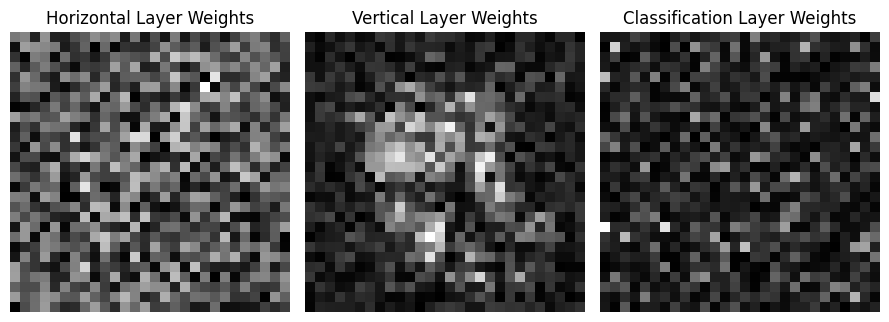

In [30]:
classification_w = np.abs(model.classification_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
vertical_w = np.abs(model.vertical_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
horizontal_w = np.abs(model.horizontal_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

fig, axes = plt.subplots(1, 3, figsize=(9, 5))

visualize_image(horizontal_w, "Horizontal Layer Weights", ax=axes[0])
visualize_image(vertical_w, "Vertical Layer Weights", ax=axes[1])
visualize_image(classification_w, "Classification Layer Weights", ax=axes[2])

plt.tight_layout()
plt.show()

# Visualizing Activations

In [31]:
model.eval()
eval_examples = list()
with torch.no_grad():
    for idx, img in enumerate(test_images[:10]):
        img_tensor = torch.from_numpy(img.copy()).float().unsqueeze(0).unsqueeze(0).to('cuda')
        out, v_act, h_act = model(img_tensor)
        
        v_act_img = v_act.clone().reshape(28, 28).detach().cpu().numpy()
        h_act_img = h_act.clone().reshape(28, 28).detach().cpu().numpy()

        label = test_labels[idx]
        eval_examples.append((label, img, out, v_act_img, h_act_img))

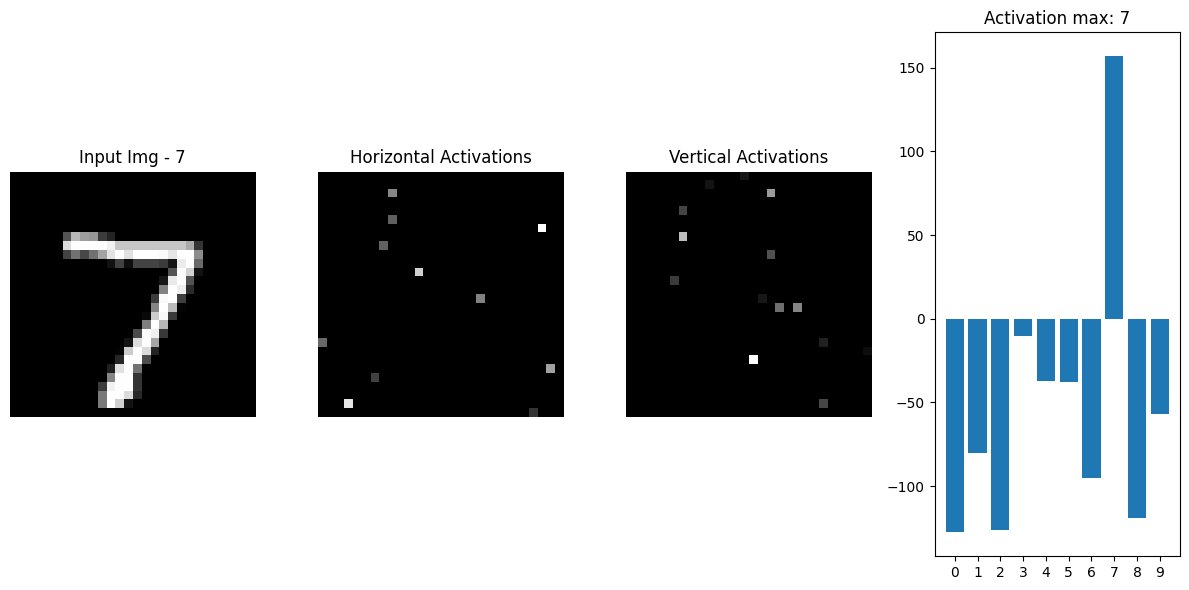

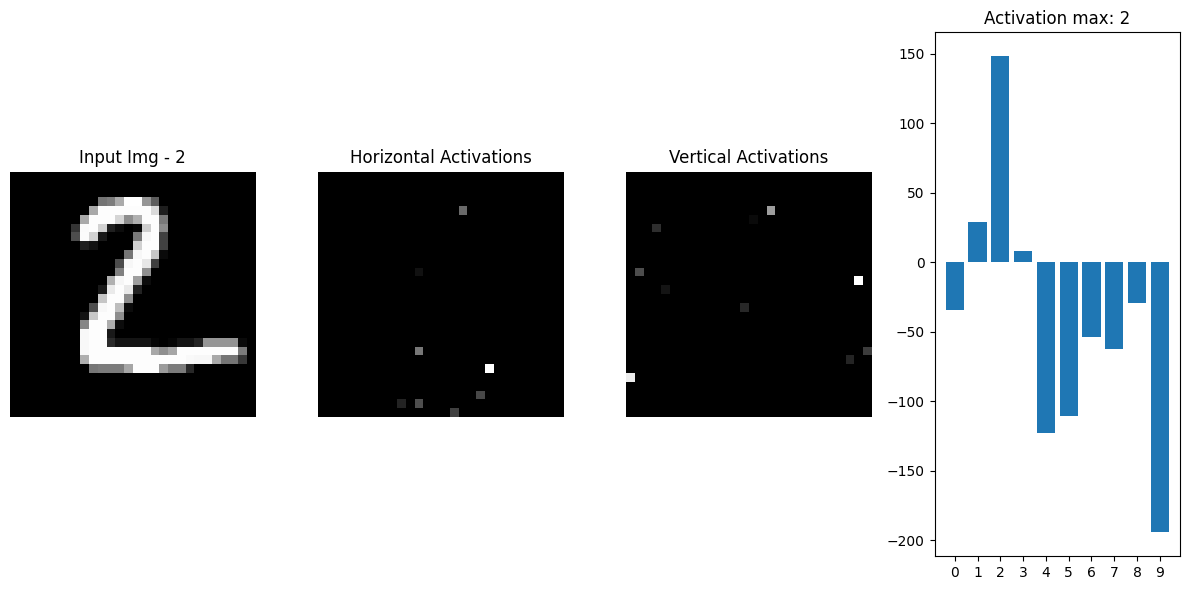

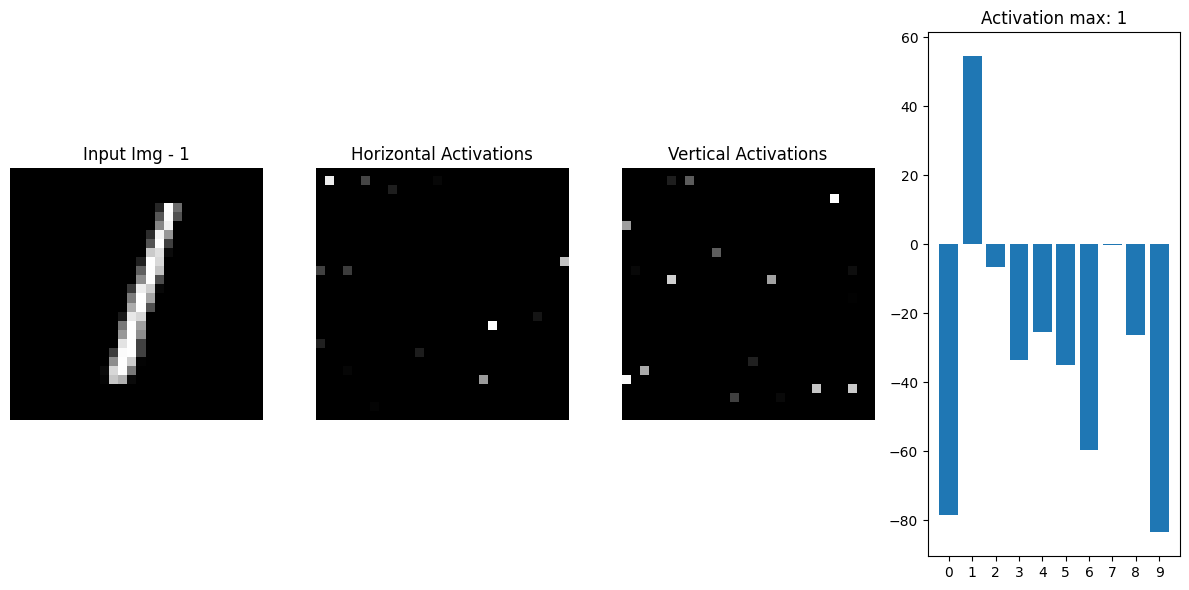

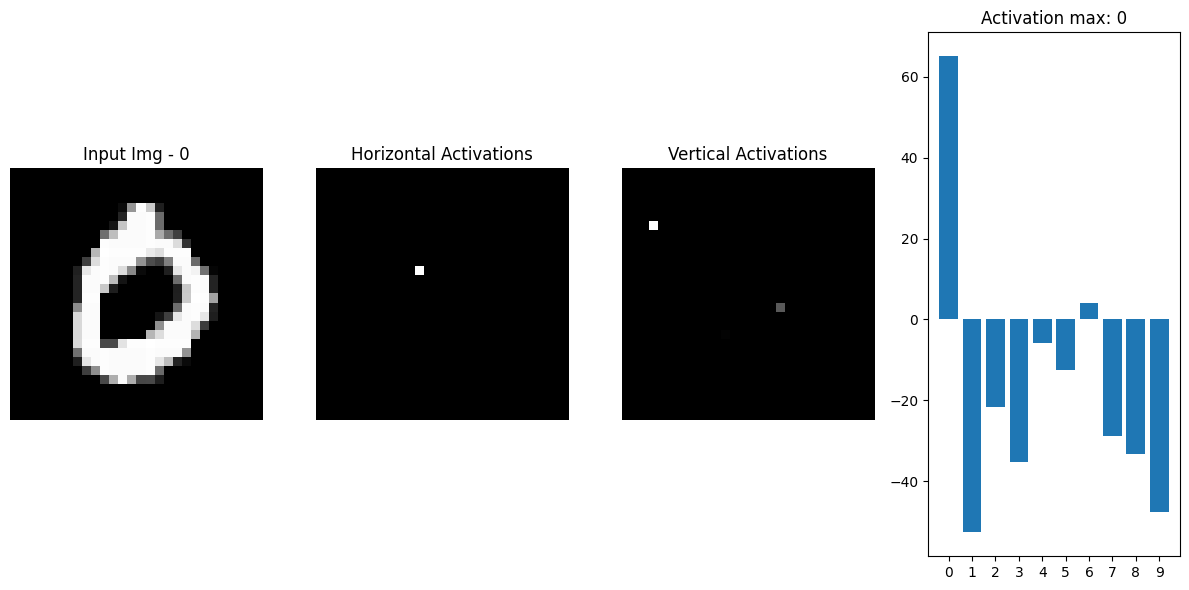

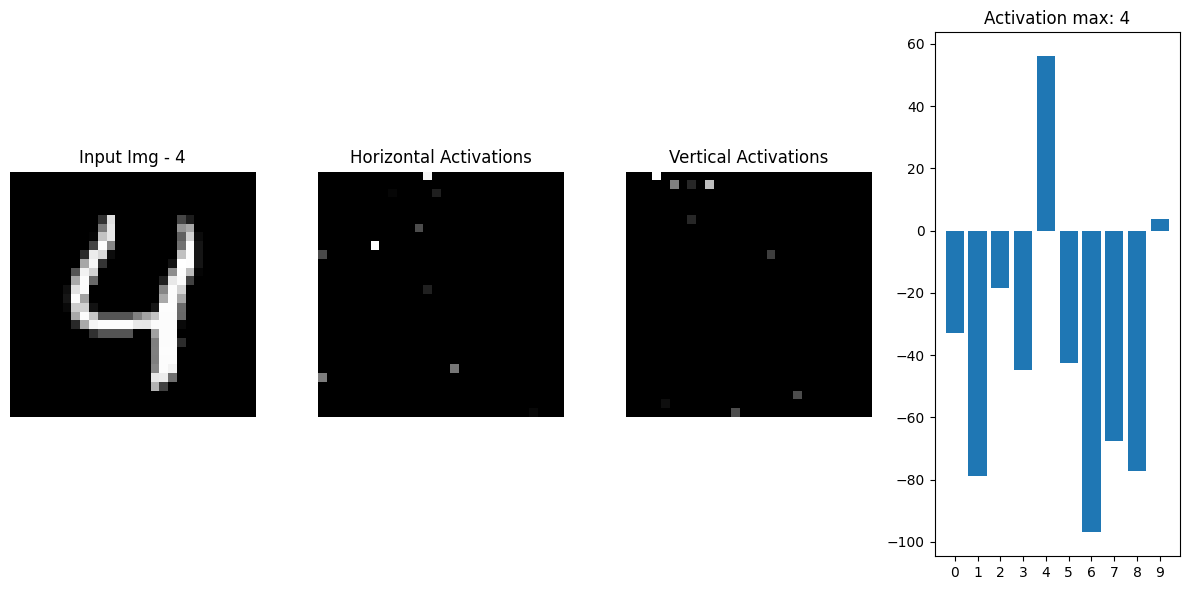

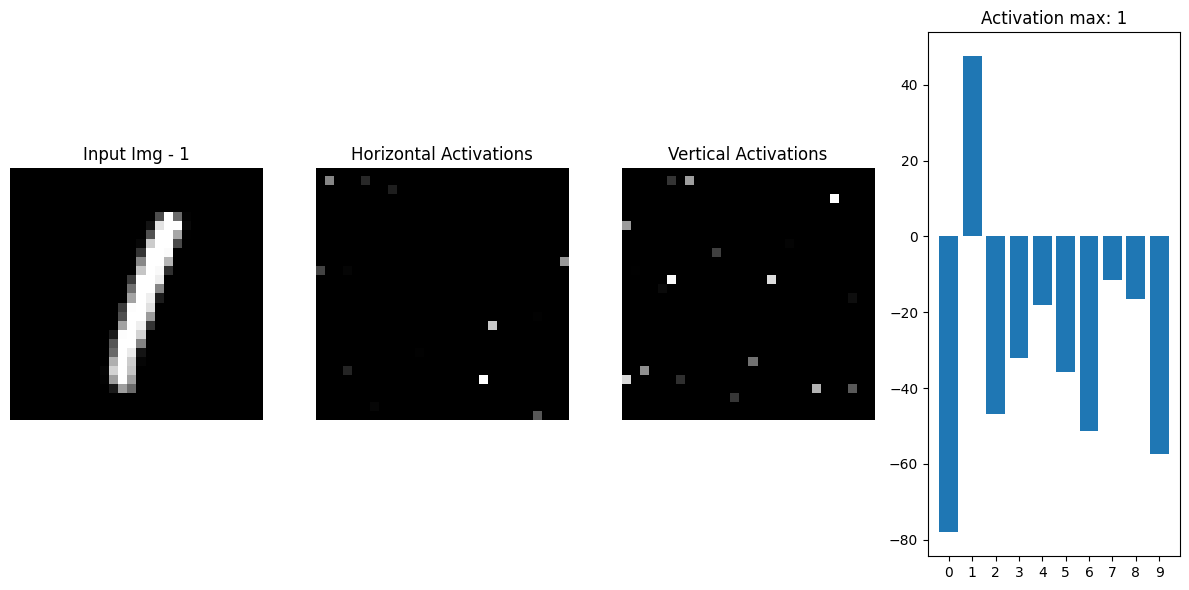

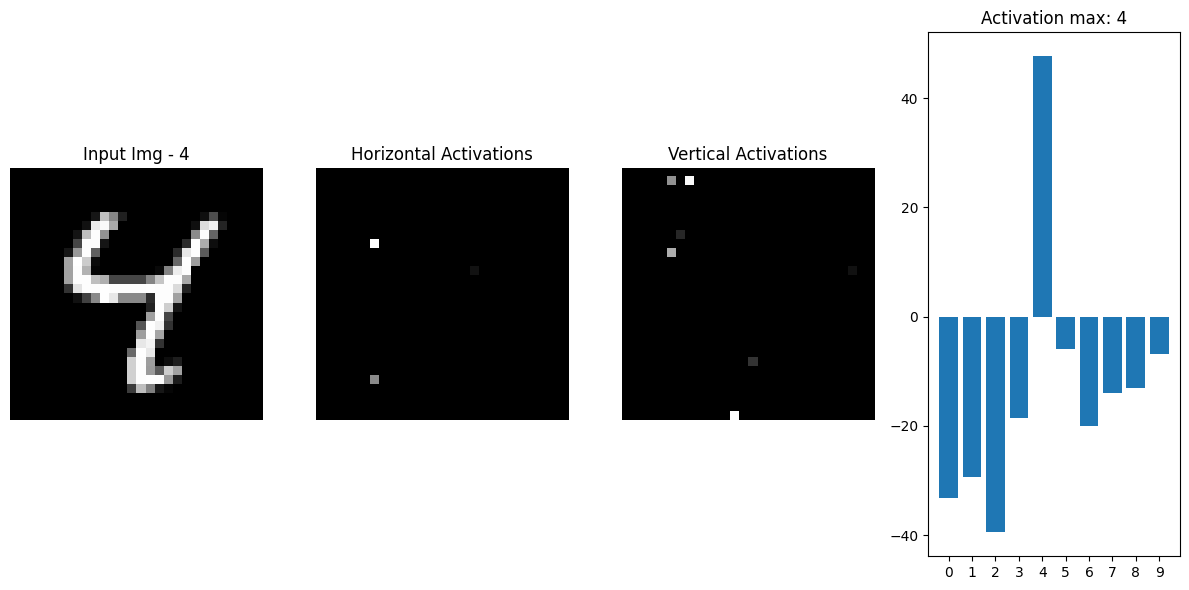

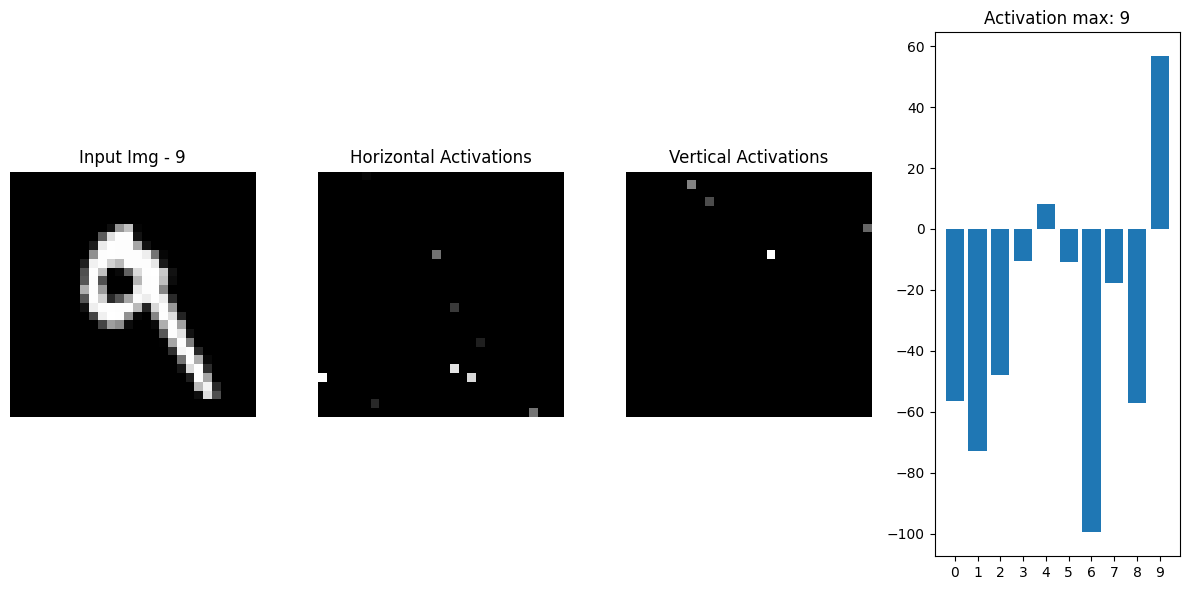

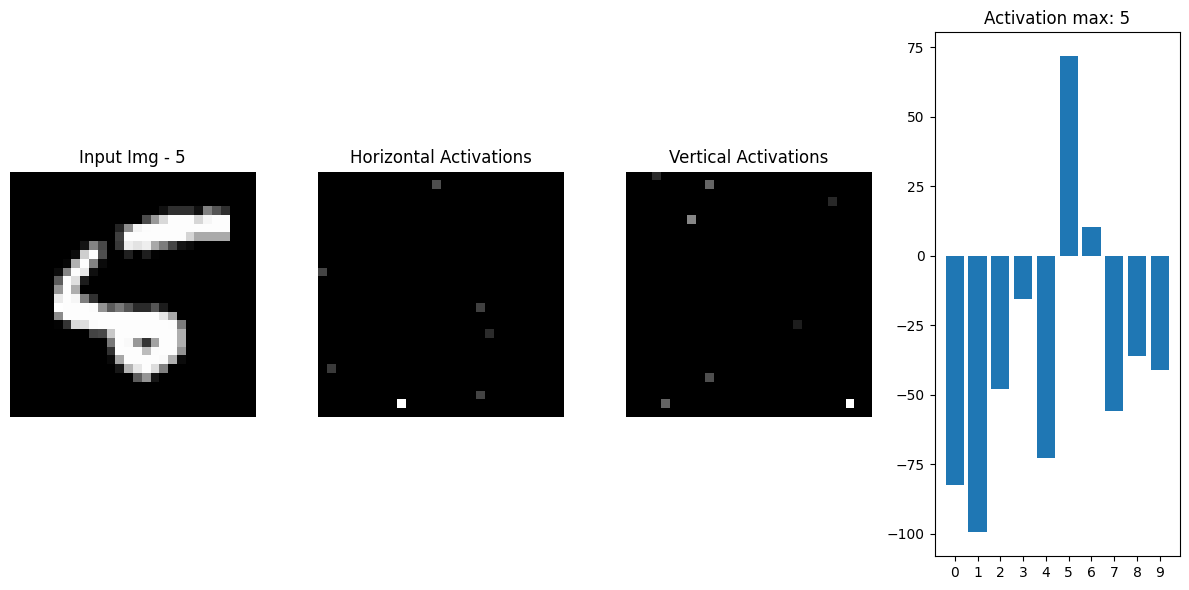

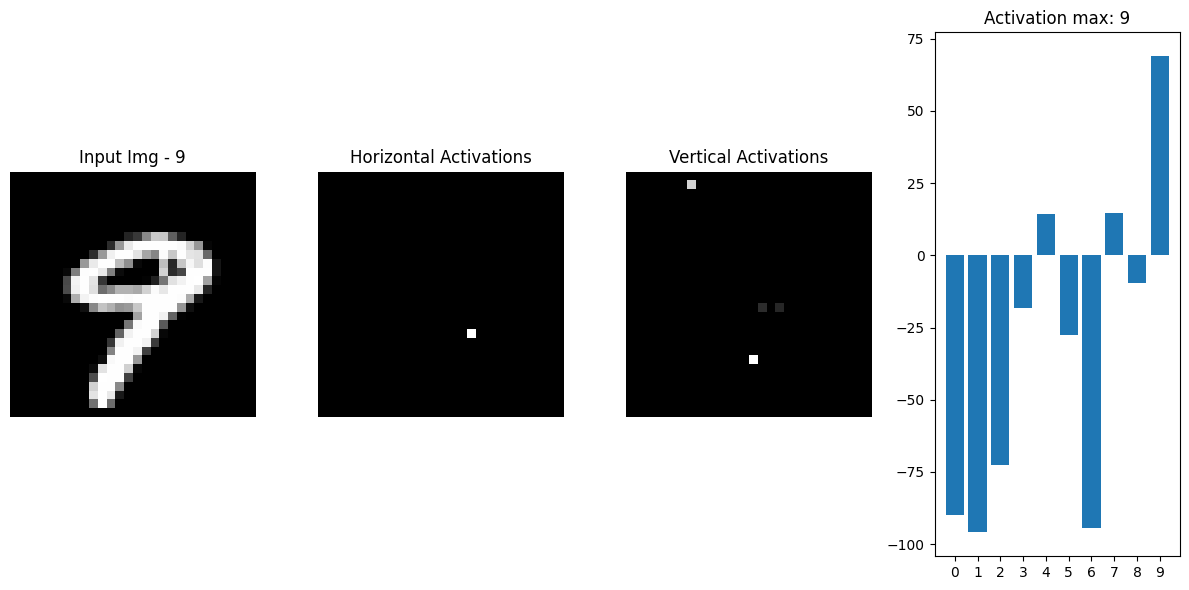

In [32]:
x_values = list(range(0, 10))
for label, img, out, v_act_img, h_act_img in eval_examples:
    inference = torch.max(out, 1)[1].item()
    fig, axes = plt.subplots(1, 4, figsize=(12, 6))

    visualize_image(img, f"Input Img - {label}", ax=axes[0])
    visualize_image(h_act_img, "Horizontal Activations", ax=axes[1])
    visualize_image(v_act_img, "Vertical Activations", ax=axes[2])

    ax3 = plt.subplot(1, 4, 4)
    bars3 = ax3.bar(x_values, out.tolist()[0])
    ax3.set_xticks(x_values)
    ax3.set_title(f"Activation max: {inference}")
    
    plt.tight_layout()
    plt.show()

# Different Inputs

## Horizontal Edges

In [33]:
model.eval()
h_edge_inputs = list()
with torch.no_grad():
    for idx, img in enumerate(test_horizontal_image_labels[:10]):
        img_tensor = torch.from_numpy(img.copy().reshape(28, 28)).float().unsqueeze(0).unsqueeze(0).to('cuda')
        out, v_act, h_act = model(img_tensor)
        
        v_act_img = v_act.clone().reshape(28, 28).detach().cpu().numpy()
        h_act_img = h_act.clone().reshape(28, 28).detach().cpu().numpy()

        label = test_labels[idx]
        h_edge_inputs.append((label, img.copy().reshape(28, 28), out, v_act_img, h_act_img))

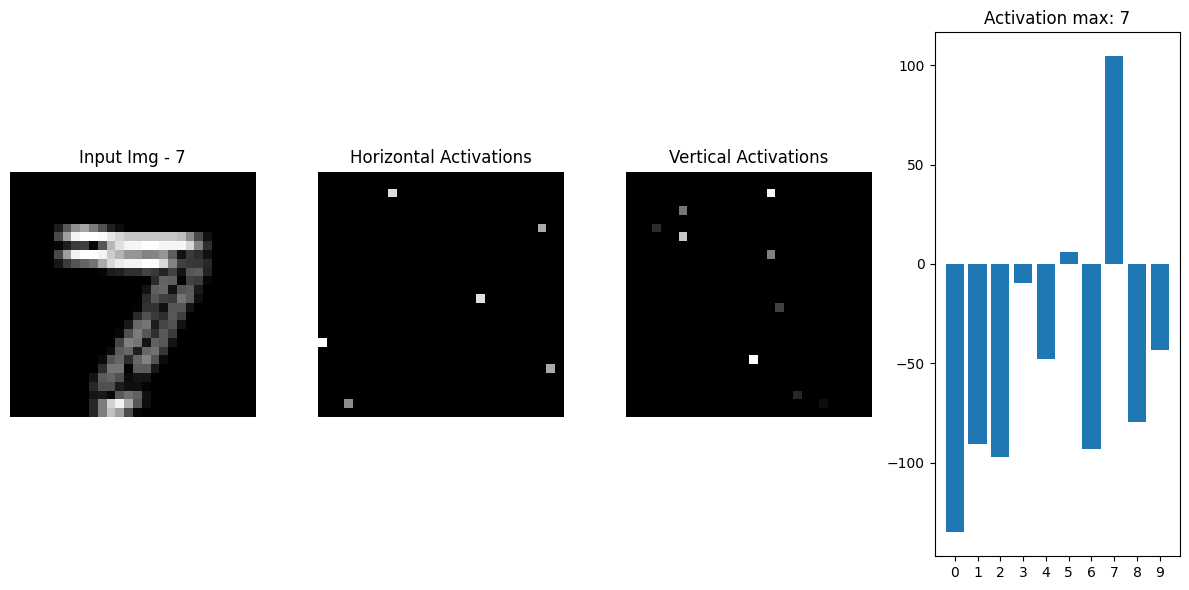

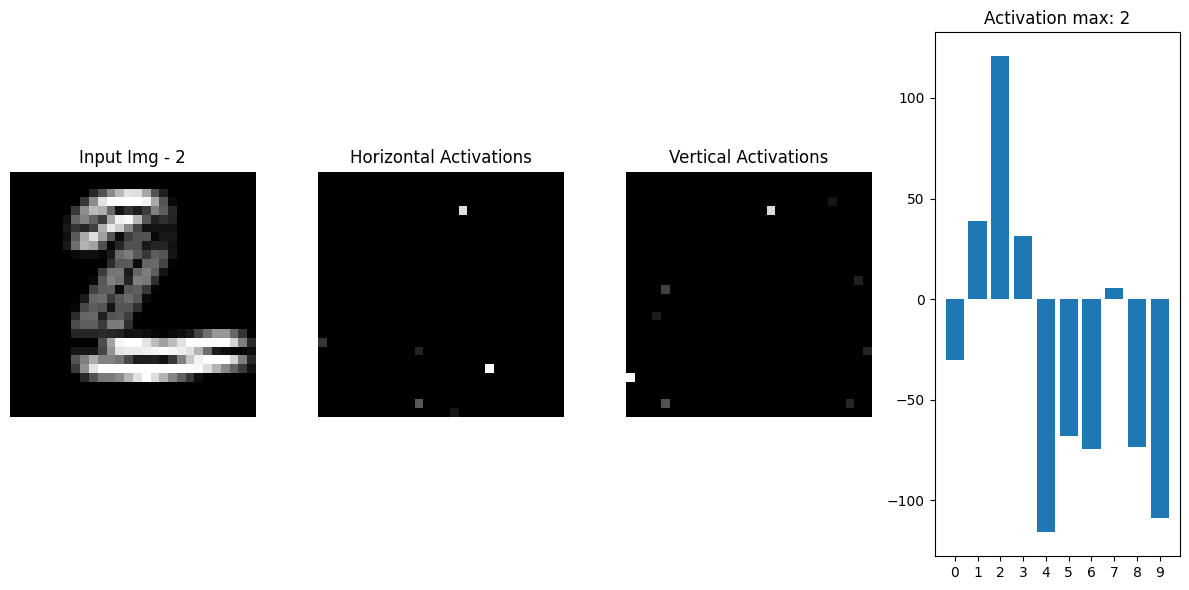

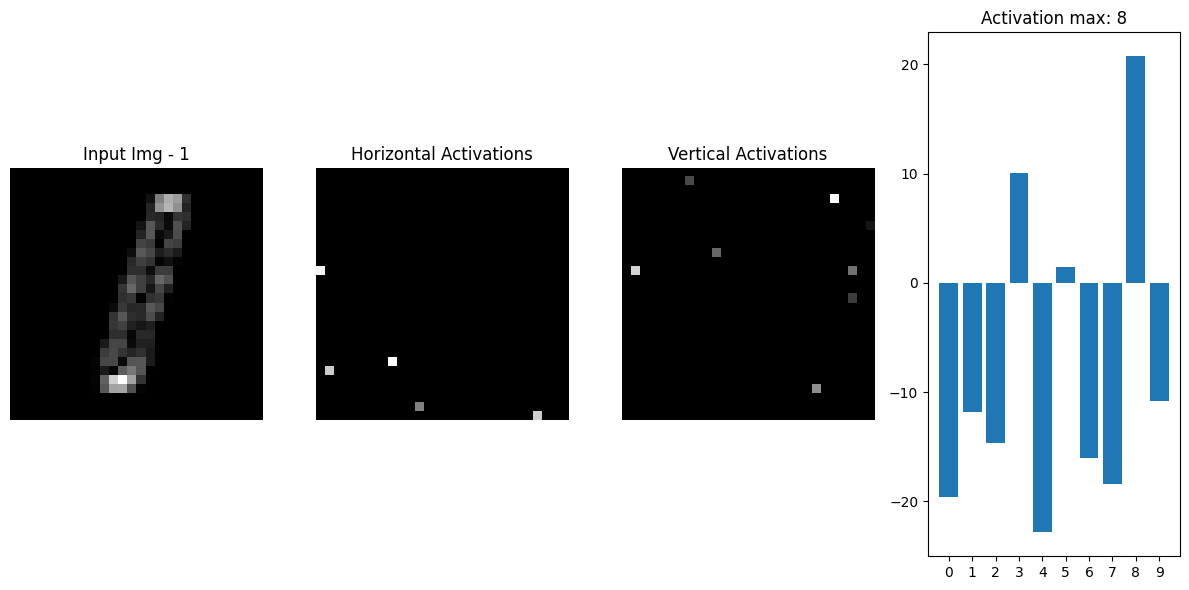

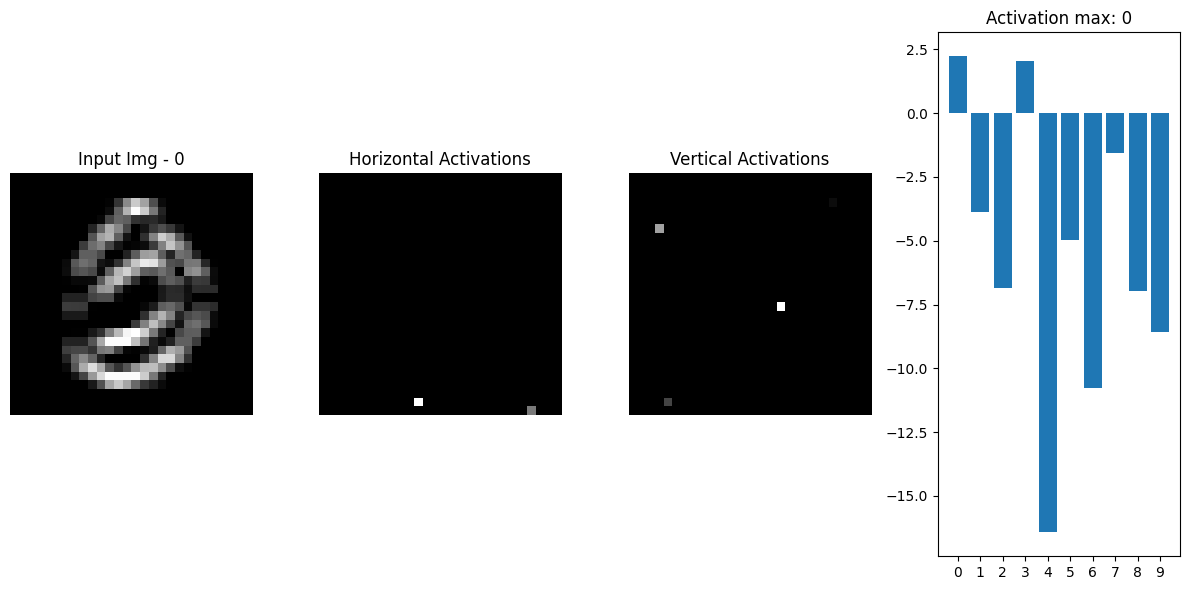

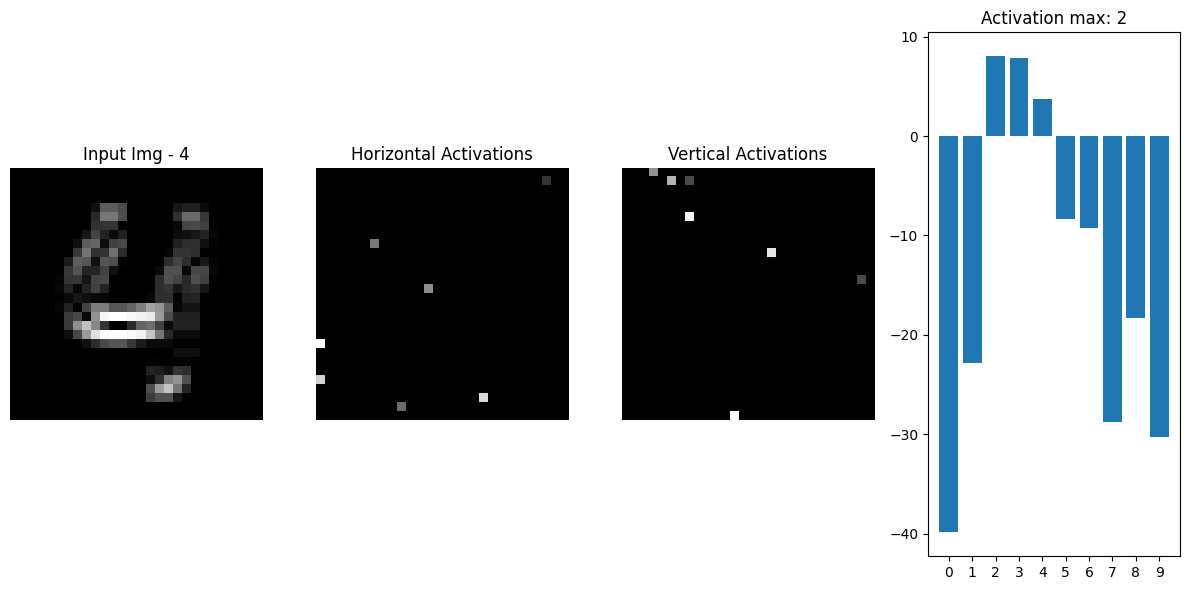

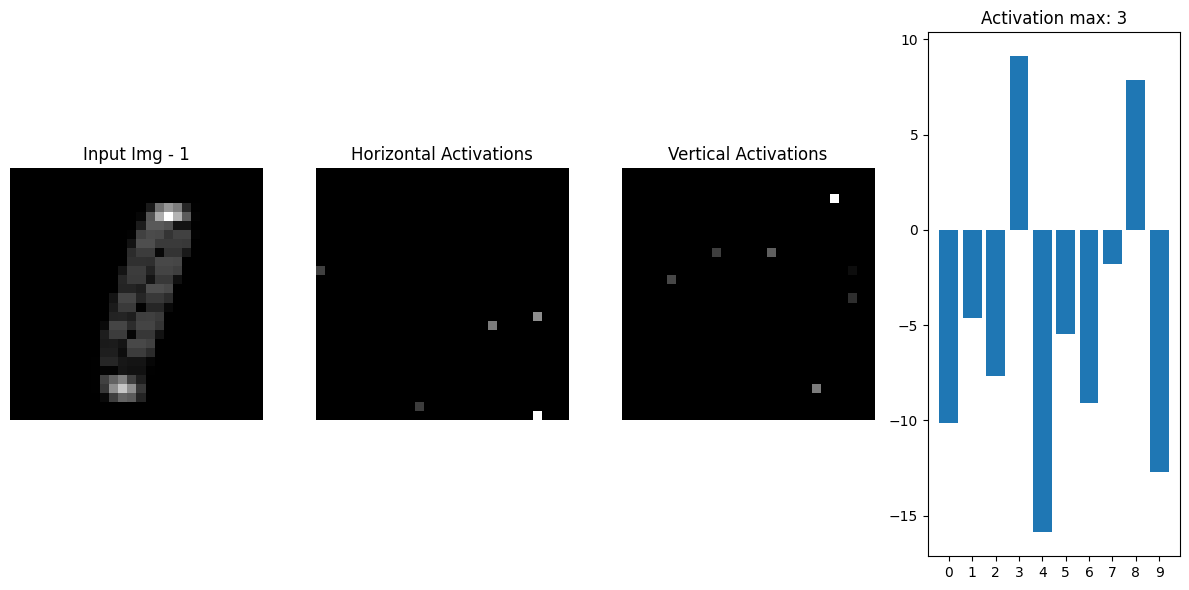

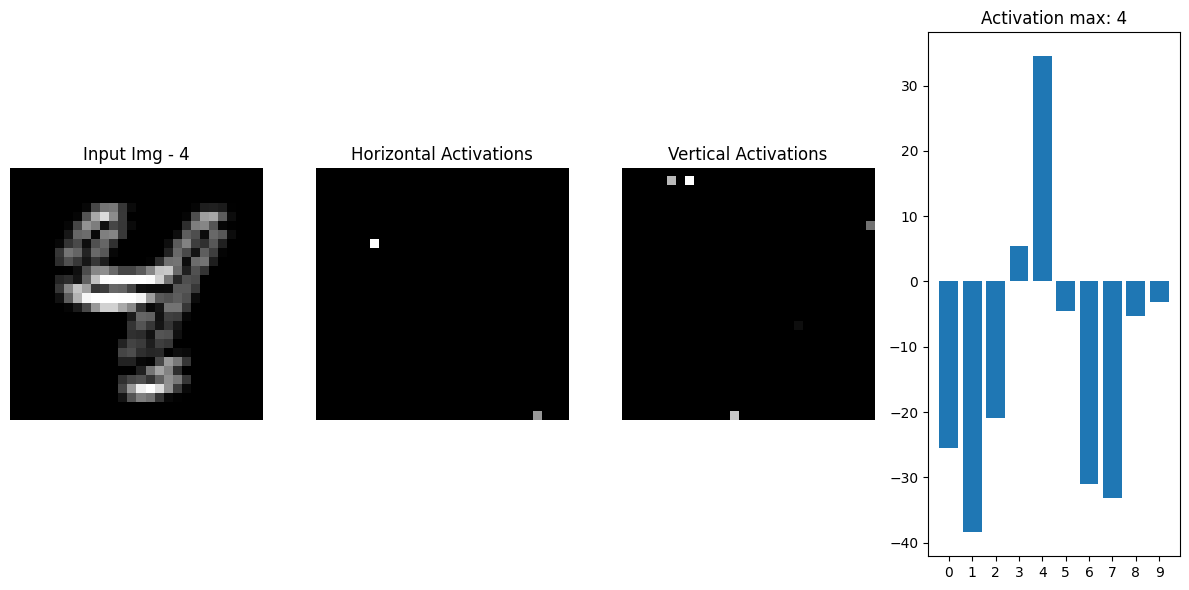

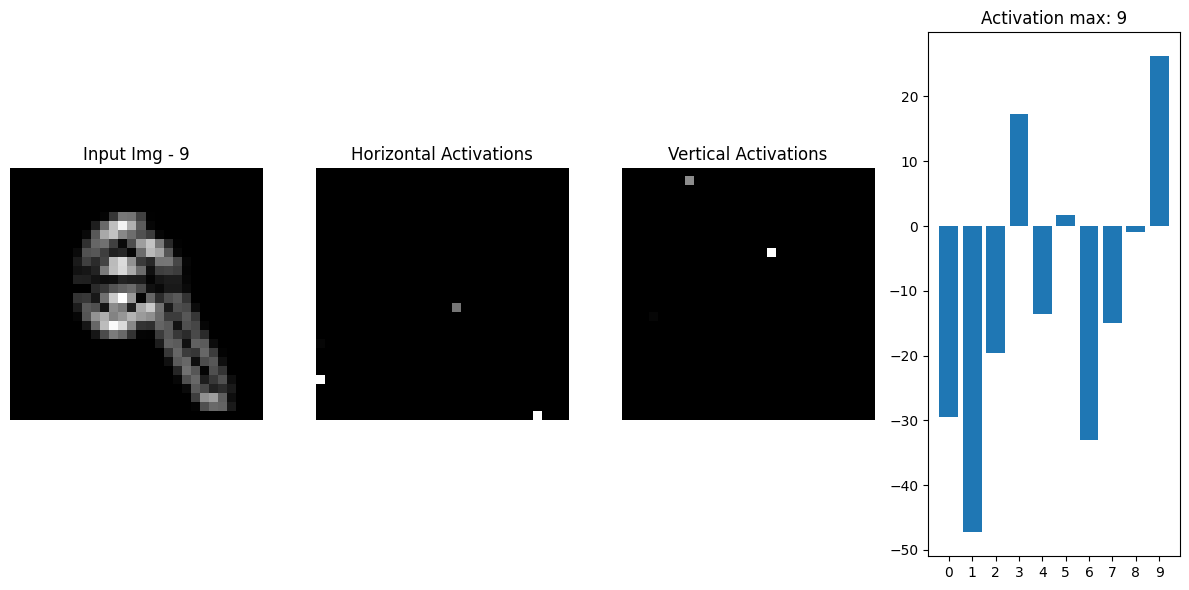

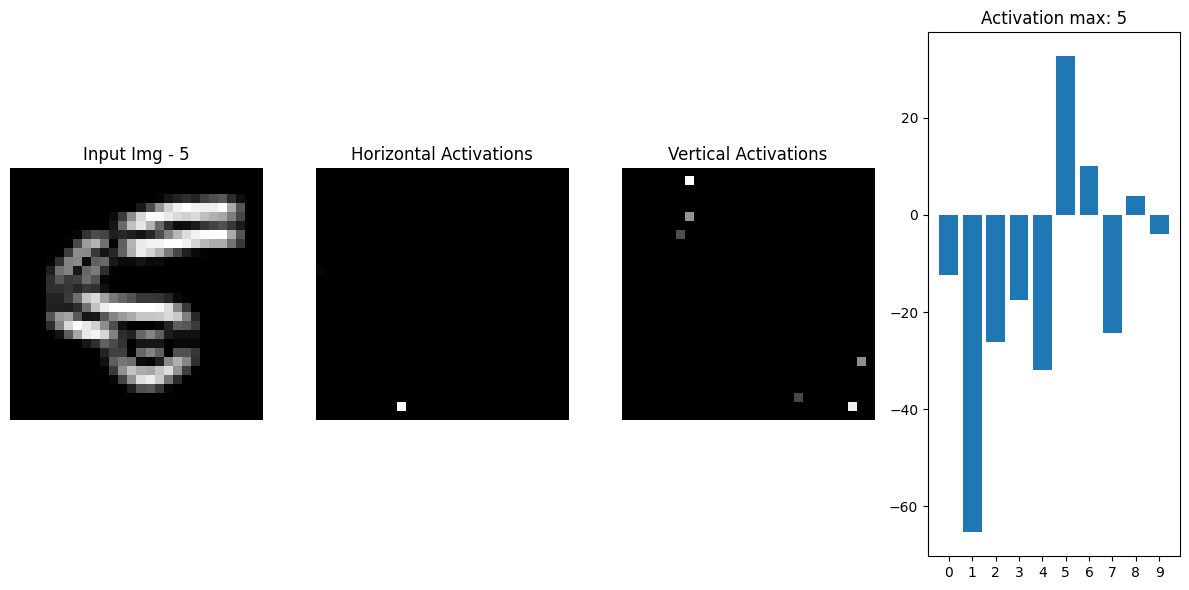

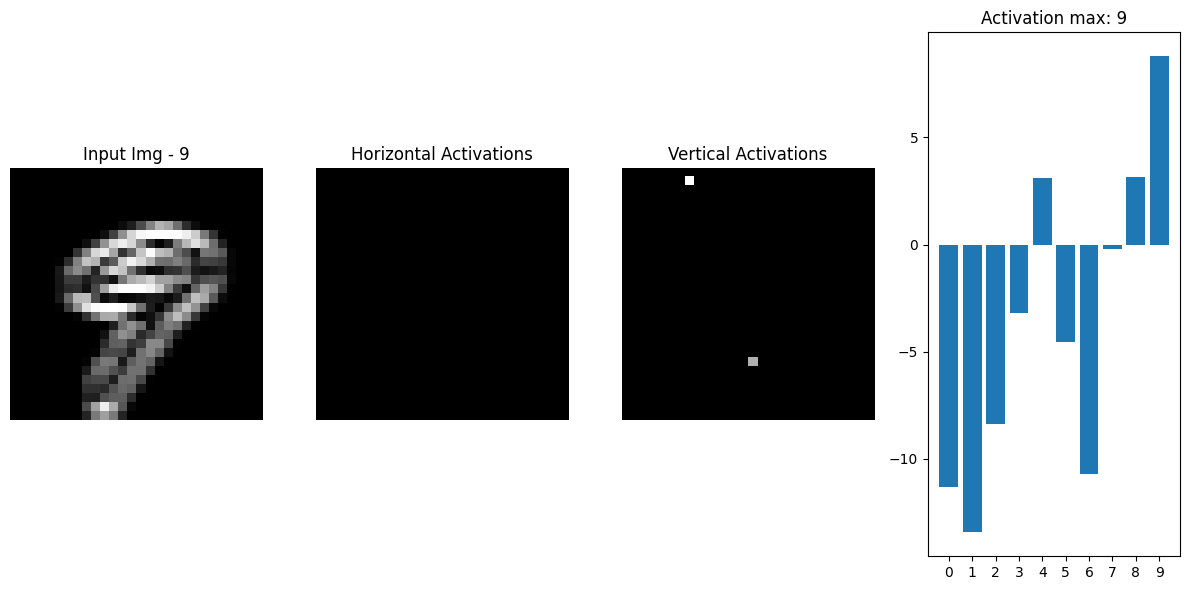

In [34]:
x_values = list(range(0, 10))
for label, img, out, v_act_img, h_act_img in h_edge_inputs:
    inference = torch.max(out, 1)[1].item()
    fig, axes = plt.subplots(1, 4, figsize=(12, 6))

    visualize_image(img, f"Input Img - {label}", ax=axes[0])
    visualize_image(h_act_img, "Horizontal Activations", ax=axes[1])
    visualize_image(v_act_img, "Vertical Activations", ax=axes[2])

    ax3 = plt.subplot(1, 4, 4)
    bars3 = ax3.bar(x_values, out.tolist()[0])
    ax3.set_xticks(x_values)
    ax3.set_title(f"Activation max: {inference}")
    
    plt.tight_layout()
    plt.show()

In [35]:
model.eval()  # again currently a no-op

test_correct = 0
test_total = 0

with torch.no_grad():
    for batch in test_loader:
        images, labels, horizontal_labels, vertical_labels = batch
        images, labels, horizontal_labels, vertical_labels = images.to(device), labels.to(device), horizontal_labels.to(device), vertical_labels.to(device)
        if len(horizontal_labels) == 128:
            h_imgs = horizontal_labels.reshape(128, 28, 28)
        else:
            h_imgs = horizontal_labels.reshape(16, 28, 28)
        
        # forward pass
        classification_out, _, _ = model(h_imgs)

        # stats
        _, predicted = torch.max(classification_out, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

Final Test Accuracy: 52.38%


## Vertical Edges

In [36]:
model.eval()
v_edge_inputs = list()
with torch.no_grad():
    for idx, img in enumerate(test_vertical_image_labels[:10]):
        img_tensor = torch.from_numpy(img.copy().reshape(28, 28)).float().unsqueeze(0).unsqueeze(0).to('cuda')
        out, v_act, h_act = model(img_tensor)
        
        v_act_img = v_act.clone().reshape(28, 28).detach().cpu().numpy()
        h_act_img = h_act.clone().reshape(28, 28).detach().cpu().numpy()

        label = test_labels[idx]
        v_edge_inputs.append((label, img.copy().reshape(28, 28), out, v_act_img, h_act_img))

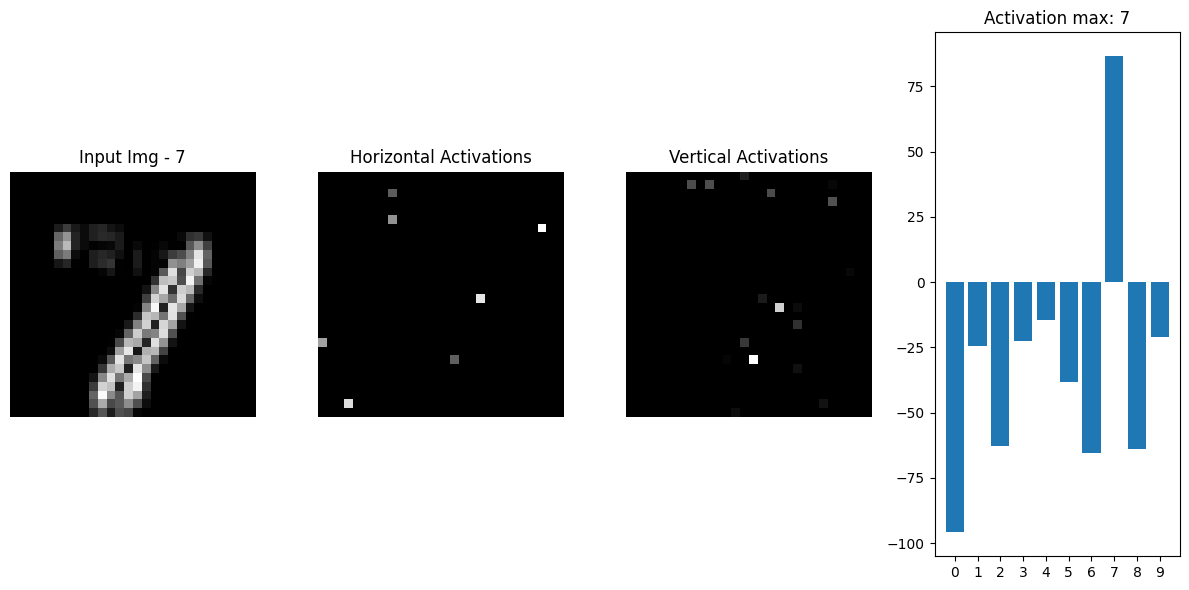

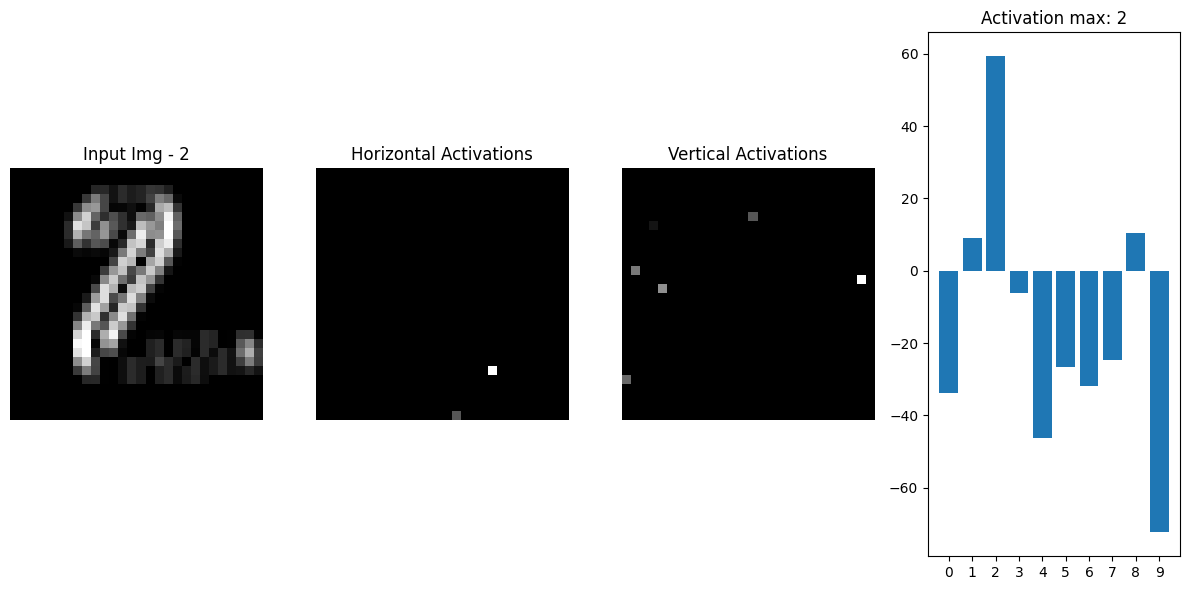

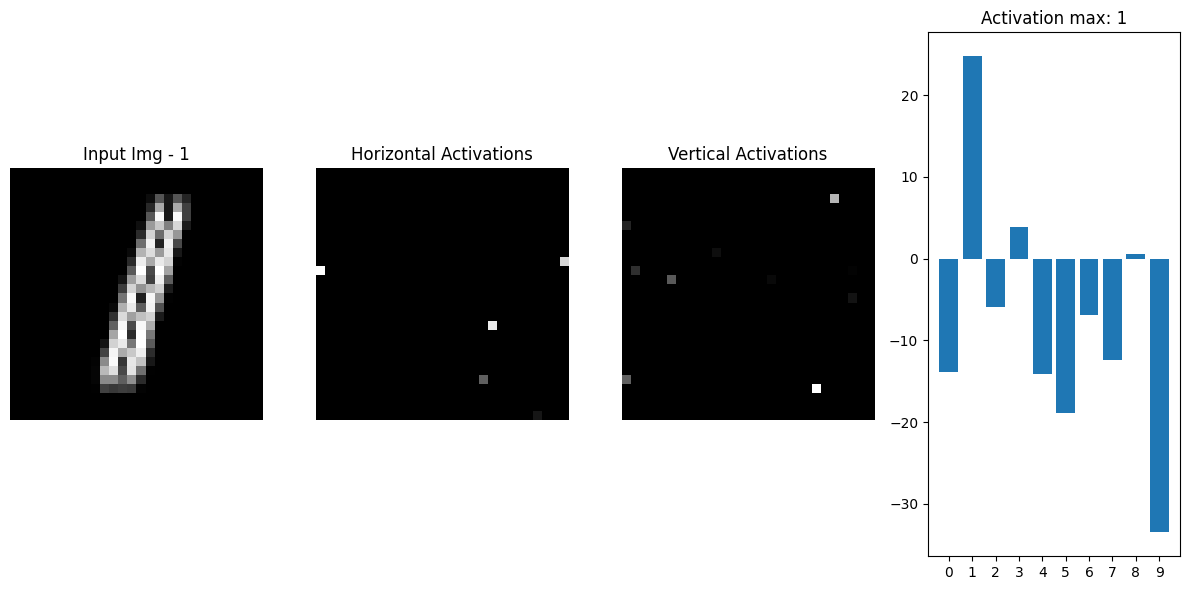

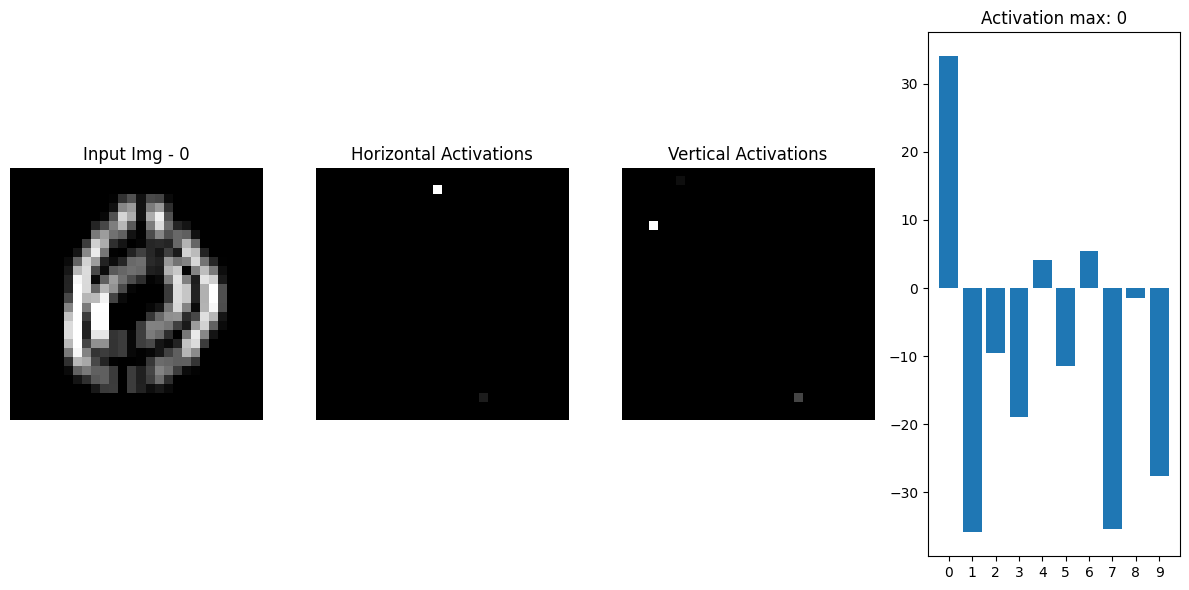

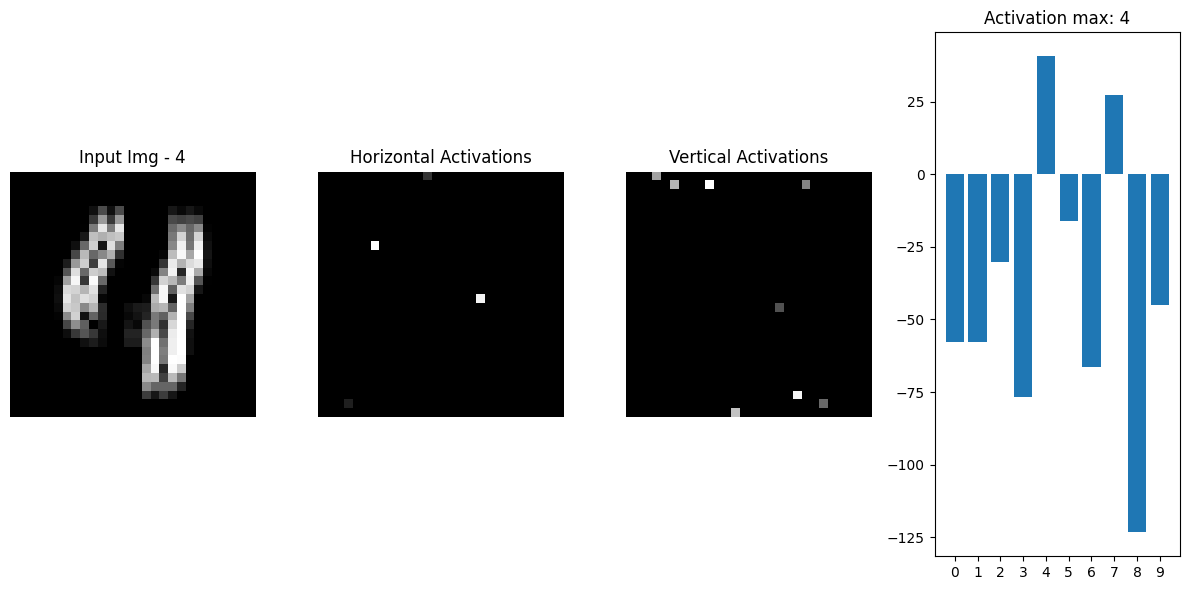

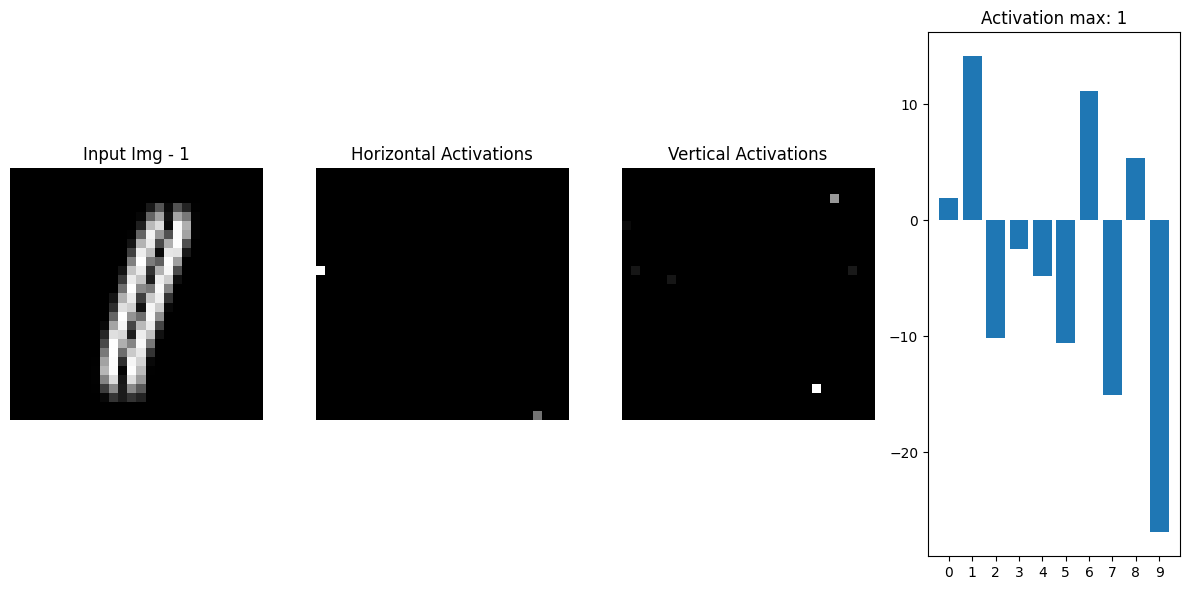

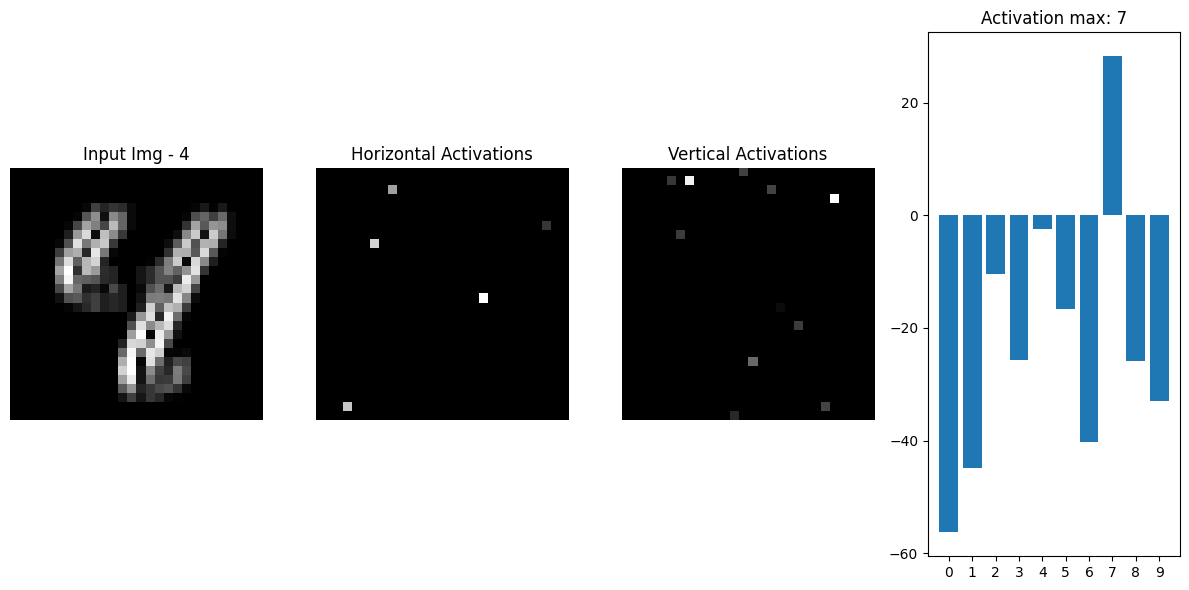

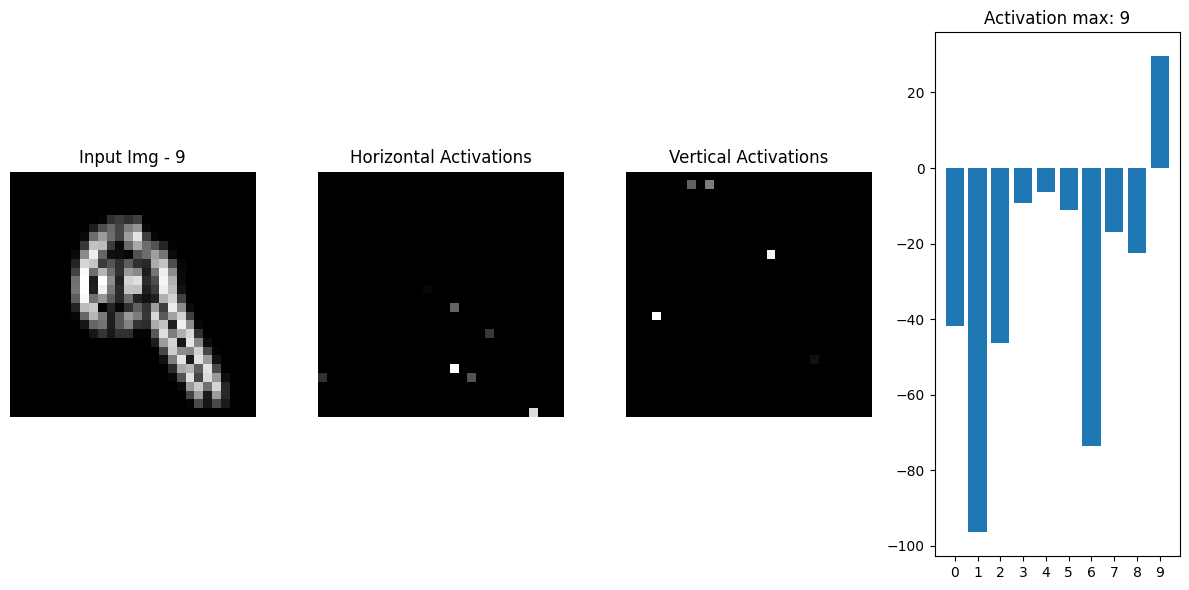

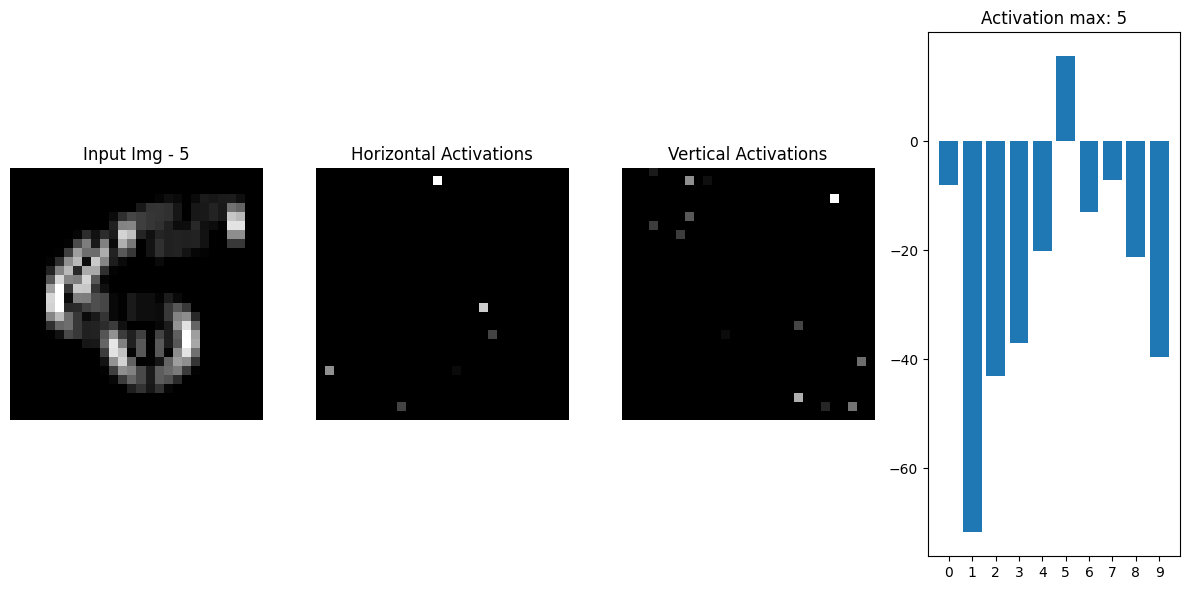

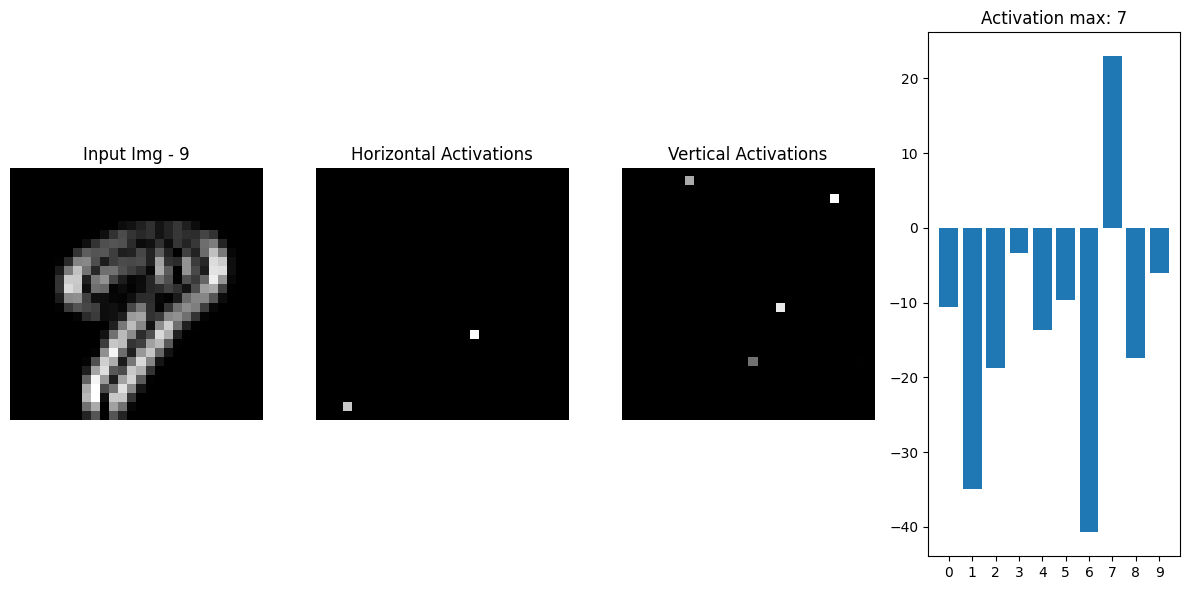

In [37]:
x_values = list(range(0, 10))
for label, img, out, v_act_img, h_act_img in v_edge_inputs:
    inference = torch.max(out, 1)[1].item()
    fig, axes = plt.subplots(1, 4, figsize=(12, 6))

    visualize_image(img, f"Input Img - {label}", ax=axes[0])
    visualize_image(h_act_img, "Horizontal Activations", ax=axes[1])
    visualize_image(v_act_img, "Vertical Activations", ax=axes[2])

    ax3 = plt.subplot(1, 4, 4)
    bars3 = ax3.bar(x_values, out.tolist()[0])
    ax3.set_xticks(x_values)
    ax3.set_title(f"Activation max: {inference}")
    
    plt.tight_layout()
    plt.show()

In [38]:
model.eval()  # again currently a no-op

test_correct = 0
test_total = 0

with torch.no_grad():
    for batch in test_loader:
        images, labels, horizontal_labels, vertical_labels = batch
        images, labels, horizontal_labels, vertical_labels = images.to(device), labels.to(device), horizontal_labels.to(device), vertical_labels.to(device)
        if len(horizontal_labels) == 128:
            v_imgs = vertical_labels.reshape(128, 28, 28)
        else:
            v_imgs = vertical_labels.reshape(16, 28, 28)
        
        # forward pass
        classification_out, _, _ = model(v_imgs)

        # stats
        _, predicted = torch.max(classification_out, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

Final Test Accuracy: 63.06%


There might be something to vertical edges being more important features than horizontal features.

## Random Inputs

In [39]:
height, width = 28, 28
noisy_images = [np.random.randint(0, 256, (height, width), dtype=np.uint8) for _ in range(0, 10000)]

In [40]:
len(noisy_images)

10000

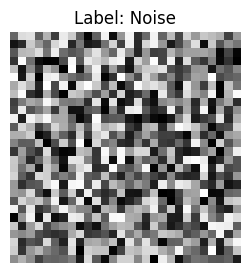

In [41]:
visualize_image(noisy_images[0], "Noise")

In [42]:
model.eval()
noisy_inputs = list()
with torch.no_grad():
    for img in noisy_images[:10]:
        img_tensor = torch.from_numpy(img.copy().reshape(28, 28)).float().unsqueeze(0).unsqueeze(0).to('cuda')
        out, v_act, h_act = model(img_tensor)
        
        v_act_img = v_act.clone().reshape(28, 28).detach().cpu().numpy()
        h_act_img = h_act.clone().reshape(28, 28).detach().cpu().numpy()

        label = "Noise"
        noisy_inputs.append((label, img, out, v_act_img, h_act_img))

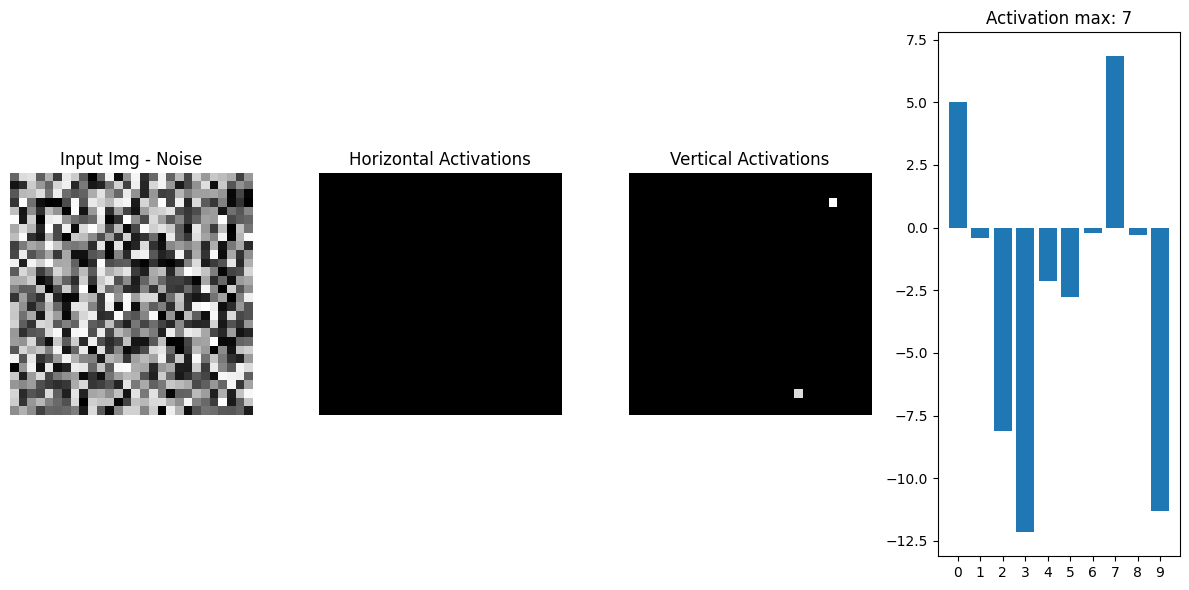

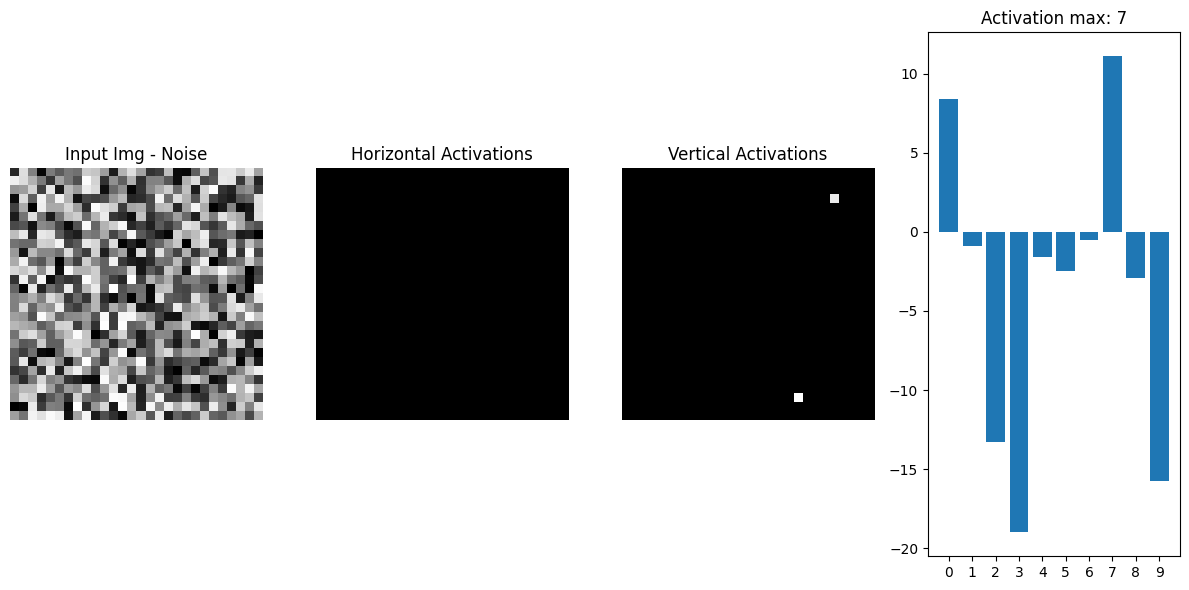

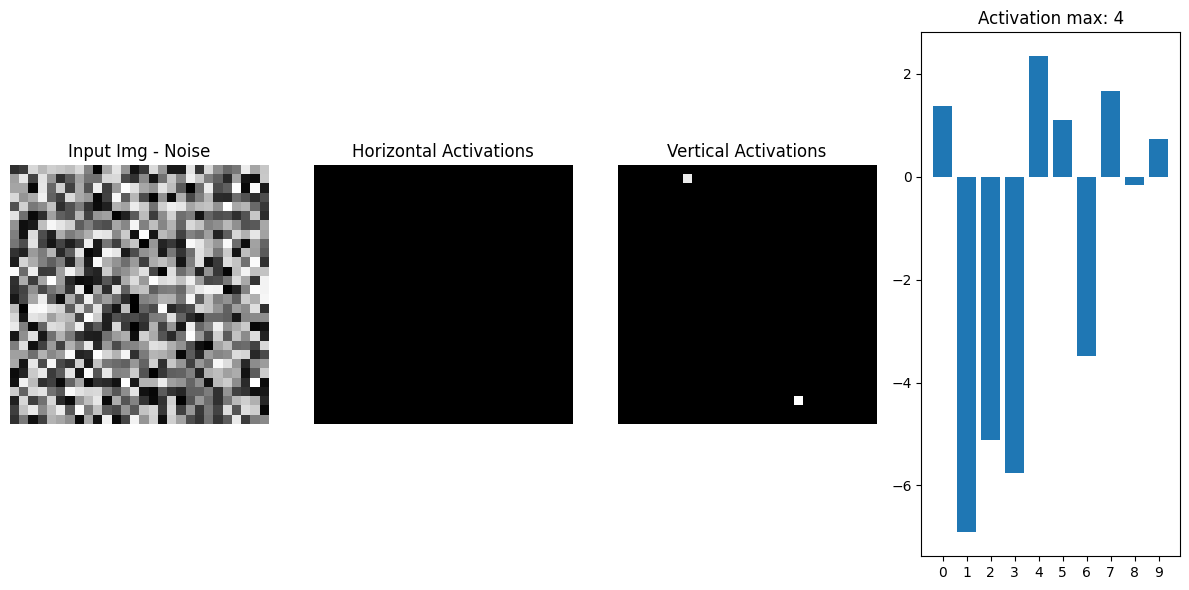

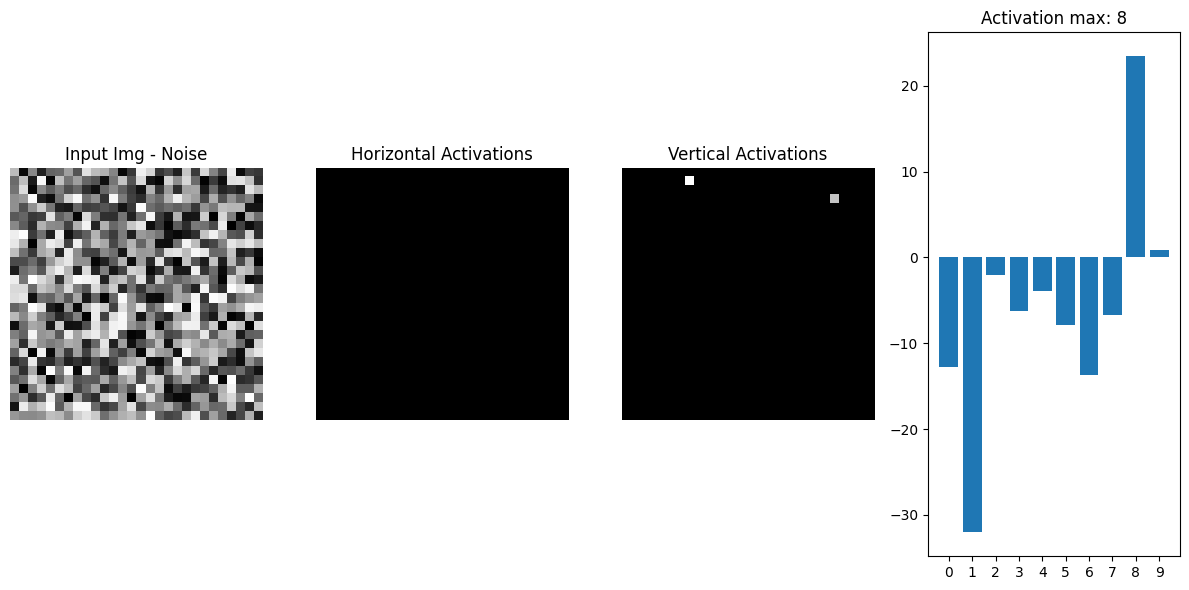

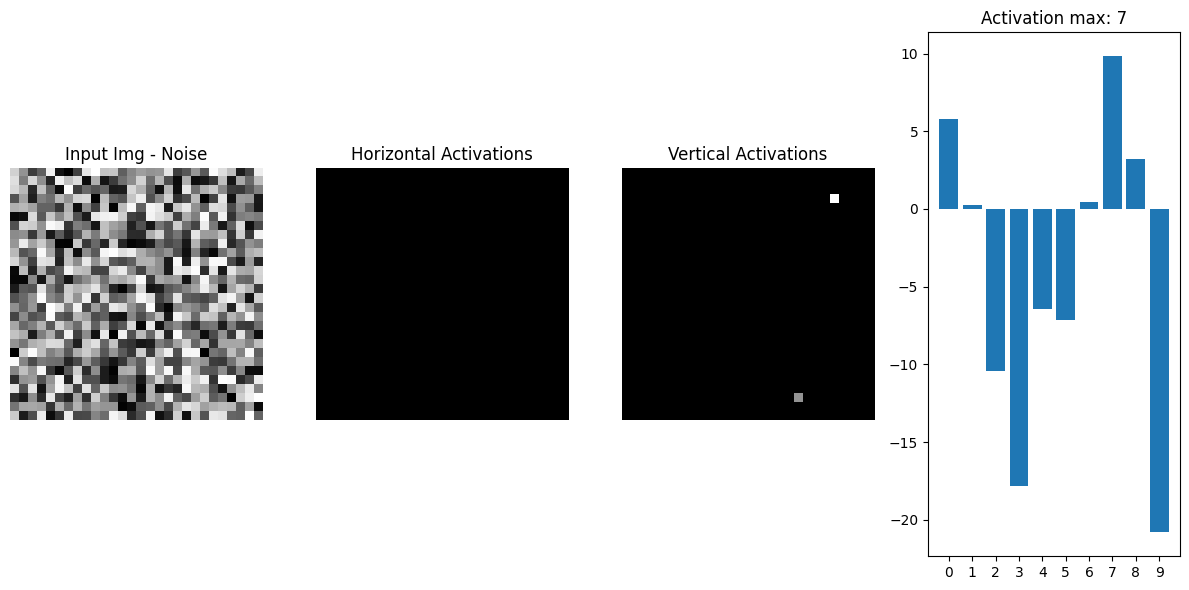

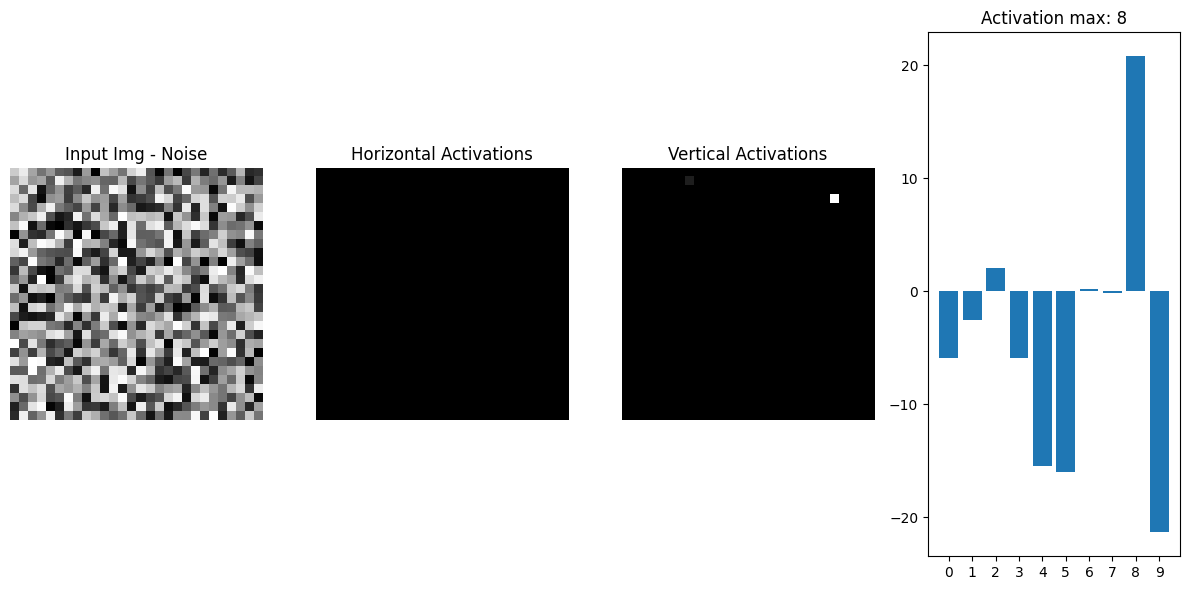

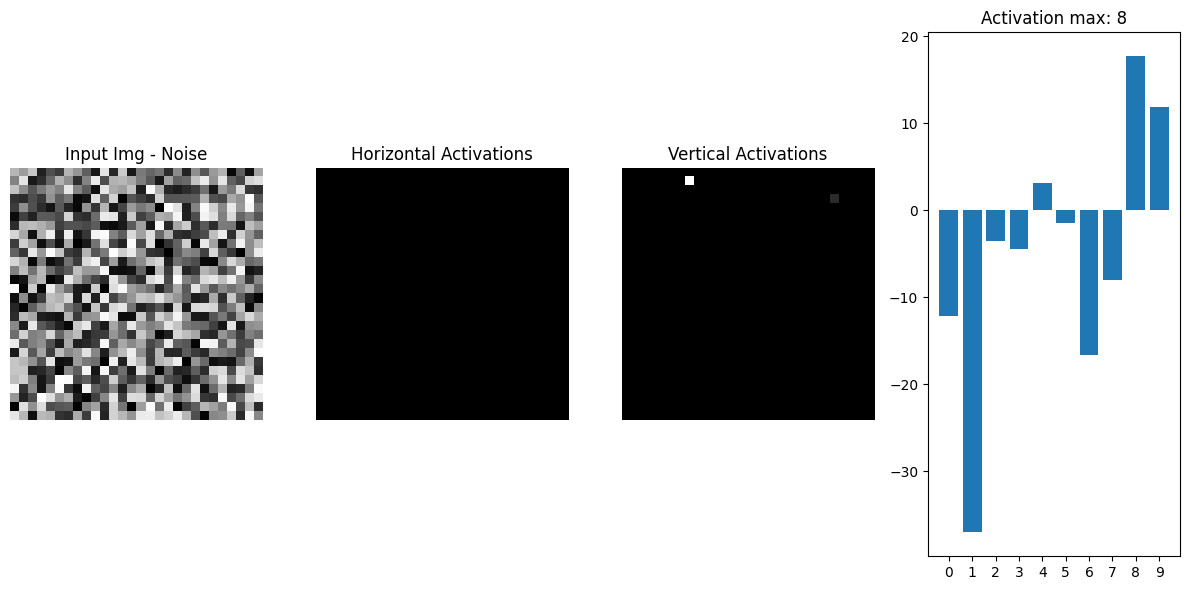

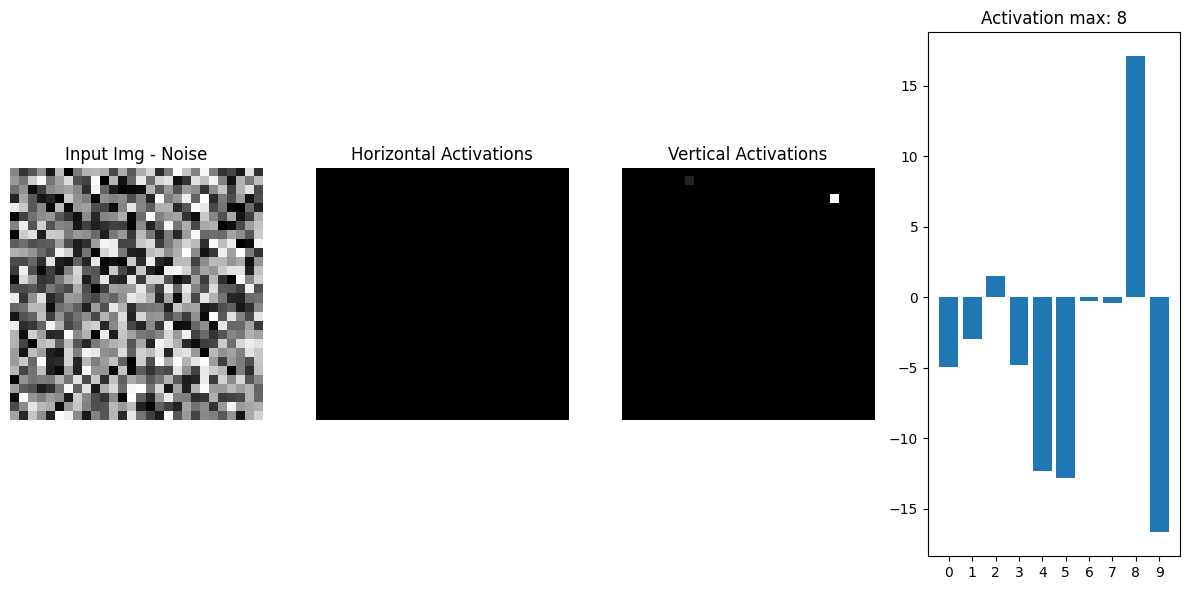

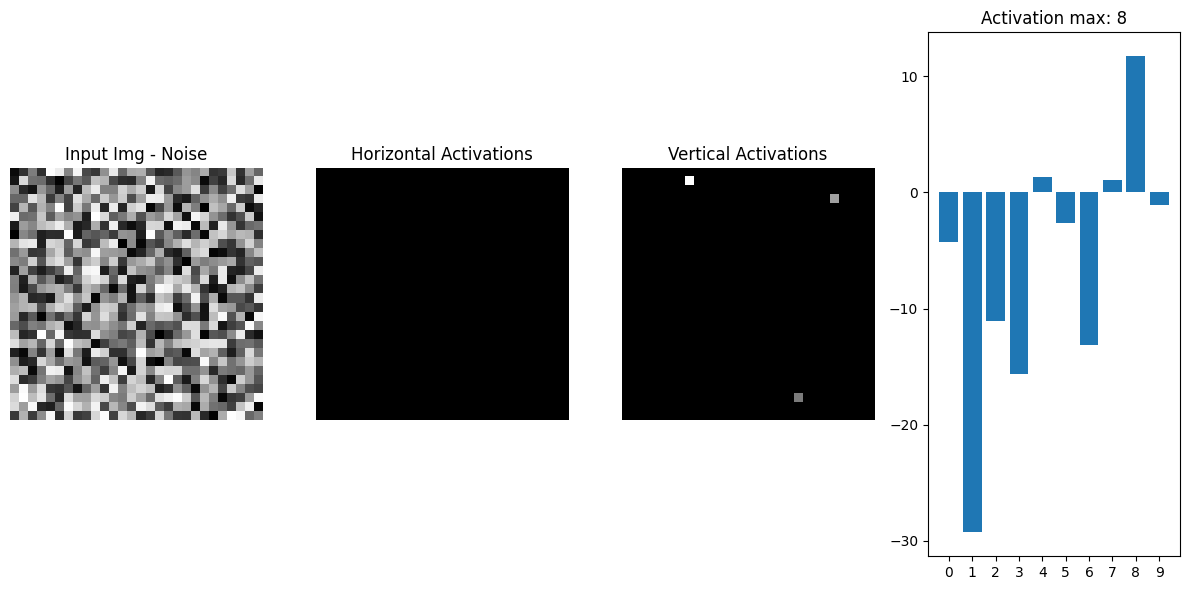

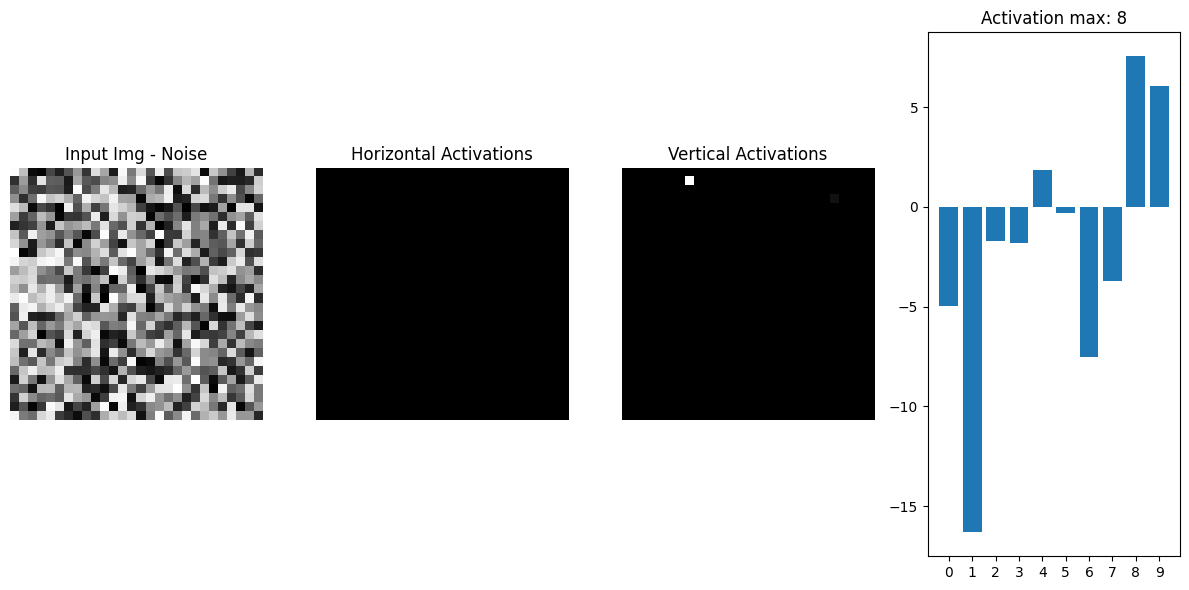

In [43]:
x_values = list(range(0, 10))
for label, img, out, v_act_img, h_act_img in noisy_inputs:
    inference = torch.max(out, 1)[1].item()
    fig, axes = plt.subplots(1, 4, figsize=(12, 6))

    visualize_image(img, f"Input Img - {label}", ax=axes[0])
    visualize_image(h_act_img, "Horizontal Activations", ax=axes[1])
    visualize_image(v_act_img, "Vertical Activations", ax=axes[2])

    ax3 = plt.subplot(1, 4, 4)
    bars3 = ax3.bar(x_values, out.tolist()[0])
    ax3.set_xticks(x_values)
    ax3.set_title(f"Activation max: {inference}")
    
    plt.tight_layout()
    plt.show()

In [44]:
model.eval()  # again currently a no-op

test_correct = 0
test_total = 0

answer_dict = {}
activation_dict = {}
with torch.no_grad():
    for img in noisy_images:
        img_tensor = torch.from_numpy(img.copy().reshape(28, 28)).float().unsqueeze(0).unsqueeze(0).to('cuda')

        # forward pass
        classification_out, _, _ = model(img_tensor)

        # stats
        _, predicted = torch.max(classification_out, 1)

        for i, act in enumerate(classification_out[0]):
            if i in activation_dict:
                activation_dict[i] += act.item()
            else:
                activation_dict[i] = act.item()

        if predicted.item() in answer_dict:
            answer_dict[predicted.item()] += 1
        else:
            answer_dict[predicted.item()] = 1
        
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

Final Test Accuracy: 6.43%


In [45]:
answer_dict

{7: 1594, 4: 125, 8: 7657, 0: 359, 9: 109, 5: 72, 3: 53, 2: 30, 6: 1}

In [46]:
sorted([(key, round(value, 2)) for key, value in activation_dict.items()], key=lambda x: x[1], reverse=True)

[(8, 89213.79),
 (7, 8227.8),
 (0, -24664.85),
 (2, -33832.66),
 (6, -40288.75),
 (4, -50736.44),
 (5, -56078.46),
 (3, -71105.39),
 (1, -81643.49),
 (9, -87061.2)]

Honestly, not a terrible distribution, but it seems our low loss factor is "best" in this regard.